In [ ]:
import numpy as np
import os
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [ ]:
dir = 'data'

if not os.path.exists(dir):
    os.makedirs(dir)

As a proof of concept of divide and conquer phyiscs informed neural networks, we consider the ODE

\begin{align*}
    \frac{d}{dt} \begin{pmatrix} y_1 \\ y_2 \end{pmatrix}(t) = \begin{pmatrix} -y_2 \\ y_1 \end{pmatrix} (t).
\end{align*}

For a given initial state $y_0 = (y_0^1, y_0^2) \in \mathbb{R}^2$, the solution $(y(t))_{t\geq0}$ flows in counter clockwise circles and is given by

\begin{align*}
    y(t) = \begin{pmatrix} y_0^1 \cos(t) - y_0^2 \sin(t) \\ y_0^2 \cos(t) + y_0^1 \sin(t) \end{pmatrix}.
\end{align*}

## 1. Setting up the ODE

In [ ]:
# the true solution

def solution_simple_ODE(t, y0):
    
    y1t = y0[0] * np.cos(t) - y0[1] * np.sin(t)
    y2t = y0[1] * np.cos(t) + y0[0] * np.sin(t)

    return np.array([y1t, y2t])

## 2. Plotting Functionality

In [ ]:
def generate_figure(figsize, xlim, ylim):
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return fig, ax


def plot_ode_solution(ax, time_series, *args, **kwargs):
    
    y = np.stack(np.array(time_series), axis=1)
    ax.plot(y[0], y[1], '.-', *args, **kwargs)
    
    return ax

## 3. Generate Training Datasets

### 3.1 Training Dataset for the Standard Approach

In [ ]:
def df_standard_approach(n_samples, delta_t, max_t, y0_max_abs, y_true, name):
    """
    y0_max_abs 
        the maximum absolute value for sampled initial states
    y_true
        callable to compute the solution y(t; y0) for a given time t and initial state y0
    """
    outfile = f"data/{name}__max_t={int(max_t)}__delta_t={delta_t:.2f}.pkl"
    
    rs = np.sqrt(np.random.uniform(0, y0_max_abs, n_samples))
    angles = np.pi * np.random.uniform(0, 2, n_samples)

    y0s = np.array([r * np.array([np.cos(a), np.sin(a)]) for r,a in zip(rs, angles)])
    times = np.arange(0, max_t, delta_t)
    
    solutions = {
        t: [y_true(t, y0) for y0 in y0s]
        for i, t in enumerate(times)
    }
    
    data = pd.DataFrame(solutions)
    
    with open(outfile, "wb") as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return outfile

In [ ]:
n_samples = 2000
delta_t = 0.05
max_t = 6
y0_max_abs = 1
y_true = solution_simple_ODE
name = "test"

file = df_standard_approach(
    n_samples=n_samples, 
    delta_t=delta_t, max_t=max_t, y0_max_abs=y0_max_abs, 
    y_true=y_true, name=name
)

with open(file, "rb") as f:
    data = pickle.load(f)

print(data.shape)
data.head()

(2000, 120)


,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,...,5.50,5.55,5.60,5.65,5.70,5.75,5.80,5.85,5.90,5.95
0,"[0.18902645109981006, 0.4240653096498703]","[0.1675957853646582, 0.43298272343343297]","[0.1457462174482924, 0.44081790590145536]","[0.12353235989146856, 0.44755127317825155]","[0.10100973576932551, 0.4531659953522995]","[0.07823463991261258, 0.4576480385422548]","[0.05526399819993094, 0.46098619997434553]","[0.03215522527268336, 0.46317213598347245]","[0.008966081028371709, 0.46420038286802606]","[-0.014245473749066123, 0.4640683705462956]",...,"[0.43315250906945885, 0.16715648342395115]","[0.4242568390441178, 0.18859618391717986]","[0.4143007478698574, 0.2095644921696092]","[0.4033091205895807, 0.23000899833069216]","[0.3913094305471597, 0.24987860178231916]","[0.3783316707183829, 0.2691236388637505]","[0.364408278744135, 0.28769600700490455]","[0.34957405585318996, 0.30554928495773004]","[0.3338660798772609, 0.3226388488251527]","[0.3173236125757319, 0.3389219835975768]"
1,"[0.4491701671960303, -0.4936182969674527]","[0.4732794538679261, -0.4705522508143339]","[0.4962057883843269, -0.44631006909305415]","[0.5178918668487459, -0.42095234463283254]","[0.5382834853589133, -0.39454245853877196]","[0.5573296754883036, -0.3671464217721049]","[0.5749828316806571, -0.33883271015716765]","[0.5911988302390792, -0.3096720932275018]","[0.6059371396123023, -0.2797374573388758]","[0.6191609217024568, -0.24910362349135404]",...,"[-0.029954292944740613, -0.6667200330979555]","[0.0034052555118486705, -0.6673838973445922]","[0.0367562926030805, -0.6663796494146823]","[0.07001545810511178, -0.6637097994050483]","[0.103099621425226, -0.6593810205502834]","[0.135926089385022, -0.6534041325431399]","[0.168412812910295, -0.6457940744909325]","[0.2004785921109891, -0.6365698675755505]","[0.23204327923863824, -0.6257545675104078]","[0.26302797901399444, -0.6133752069131682]"
2,"[-0.689694168197357, -0.5545051916445336]","[-0.6611185212453279, -0.588282546122674]","[-0.6308904222940555, -0.6205895006071352]","[-0.5990854258484283, -0.6513453045368427]","[-0.5657830278358387, -0.6804730844192852]","[-0.5310664669077643, -0.7079000359742113]","[-0.4950225163864899, -0.7335576061064136]","[-0.4577412673769922, -0.7573816642527662]","[-0.4193159035860958, -0.7793126626752327]","[-0.37984246841173525, -0.7992957852992001]",...,"[-0.879991183949776, 0.09364597896790039]","[-0.8835717723494686, 0.04954771753980086]","[-0.884943891473571, 0.0053256126218051425]","[-0.8841041117388592, -0.03890980355421958]","[-0.8810545321573207, -0.08304796548519283]","[-0.8758027750897194, -0.1269785507529973]","[-0.8683619671936617, -0.17059175577307106]","[-0.8587507066137903, -0.2137785702461802]","[-0.8469930164961068, -0.2564310496274012]","[-0.8331182849426191, -0.29844258493126274]"
3,"[-0.48158647847828445, 0.5112015254418392]","[-0.5065340483543681, 0.4864933645230048]","[-0.5302155469073986, 0.46056922355370933]","[-0.5525717827240795, 0.43349389938534444]","[-0.5735468768577716, 0.40533506622777477]","[-0.5930884024967586, 0.3761631064990575]","[-0.6111475160039728, 0.3460509349060514]","[-0.6276790790006508, 0.31507381619562314]","[-0.6426417711887722, 0.2833091770319774]","[-0.6559981936302862, 0.25083641247031885]",...,"[0.019387509687387616, 0.7020517504680833]","[-0.015724682924732558, 0.7021433402191429]","[-0.050797572018796866, 0.7004799372888374]","[-0.08574349363767819, 0.6970656993182092]","[-0.12047510117681365, 0.6919091601240838]","[-0.1549055837052269, 0.685023208368973]","[-0.1889488829476461, 0.6764250553461302]","[-0.2225199083853716, 0.666136191960281]","[-0.2555347499382618, 0.6541823350115535]","[-0.2879108876962315, 0.6405933629168714]"
4,"[-0.22609177853359905, 0.006431813356944437]","[-0.22613067937207723, -0.004876104004979384]","[-0.22560437127870647, -0.016171833646316636]","[-0.22451416974962418, -0.02742714212566625]","[-0.22286279972088718, -0.038613897033481184]","[-0.2206543887575504, -0.049704137308441254]","[-0.2178944567

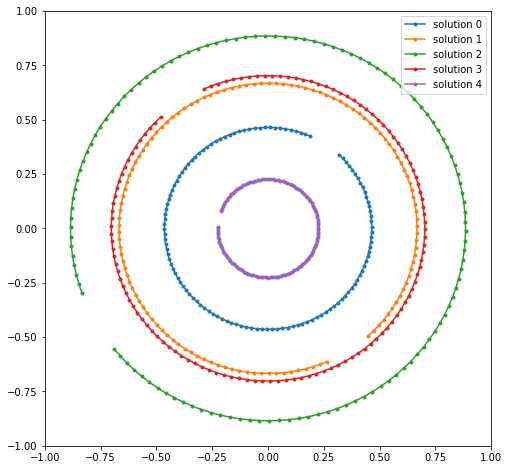

In [ ]:
fig, ax = generate_figure(figsize=(8,8), xlim=[-1, 1], ylim=[-1, 1])

for index, row in data.iterrows():
    
    if index < 5:
        ax = plot_ode_solution(ax, row, label=f"solution {index}")
    else:
        break

plt.legend()
plt.show()

In [ ]:
def data_standard_approach(infile):
    
    with open(infile, "rb") as f:
        data = pickle.load(f)
    
    times = data.columns.to_numpy()
    times = np.around(times, decimals=5)
    
    y0s = data.iloc[:,0].to_numpy()
    ty0s = [np.concatenate(([t], y0)) for y0 in y0s for t in times]
    yty0s = list(data.to_numpy().flatten())
    
    standard_data = pd.DataFrame({"input": ty0s, "output": yty0s})
    
    name = infile.split("/")[-1]
    name, info = name.split("__", 1)
    outfile = f"data/{name}_standard__{info}"
    
    with open(outfile, "wb") as handle:
        pickle.dump(standard_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return outfile

In [ ]:
file_standard = data_standard_approach(file)

with open(file_standard, "rb") as f:
    standard_data = pickle.load(f)

print(standard_data.shape)
standard_data.head()

(240000, 2)


,input,output
0,"[0.0, 0.18902645109981006, 0.4240653096498703]","[0.18902645109981006, 0.4240653096498703]"
1,"[0.05, 0.18902645109981006, 0.4240653096498703]","[0.1675957853646582, 0.43298272343343297]"
2,"[0.1, 0.18902645109981006, 0.4240653096498703]","[0.1457462174482924, 0.44081790590145536]"
3,"[0.15, 0.18902645109981006, 0.4240653096498703]","[0.12353235989146856, 0.44755127317825155]"
4,"[0.2, 0.18902645109981006, 0.4240653096498703]","[0.10100973576932551, 0.4531659953522995]"


### 3.2 Training Dataset for the Divide and Conquer Approach

In [ ]:
def data_dac_approach(infile, t_star):
    
    with open(infile, "rb") as f:
        data = pickle.load(f)
    
    times = data.columns.to_numpy()
    times = np.around(times, decimals=5)
    
    try:
        index_diff = np.where(times == t_star)[0][0]
    except ValueError:
        print(f"The time difference {t_star} has to match a standard training data time step.")
        raise
    
    y0s = []
    ytstars = []
    
    index = 0
    
    # Note: Iterating over columns is preferred for pandas dataframes
    while index + index_diff < len(data.columns):
        
        y0s.extend(data.iloc[:, index])
        ytstars.extend(data.iloc[:, index + index_diff])
        
        index += 1
    
    dac_data = pd.DataFrame({0: y0s, t_star: ytstars})
    
    name = infile.split("/")[-1]
    name = name.split("__")[0]
    outfile = f"data/{name}_dac__t_star={t_star:.2f}.pkl"
    
    with open(outfile, "wb") as handle:
        pickle.dump(dac_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    return outfile

In [ ]:
tstar = 0.05
file_dac = data_dac_approach(file, tstar)

with open(file_dac, "rb") as f:
    dac_data = pickle.load(f)

print(dac_data.shape)
dac_data.head()

(238000, 2)


,0.00,0.05
0,"[0.18902645109981006, 0.4240653096498703]","[0.1675957853646582, 0.43298272343343297]"
1,"[0.4491701671960303, -0.4936182969674527]","[0.4732794538679261, -0.4705522508143339]"
2,"[-0.689694168197357, -0.5545051916445336]","[-0.6611185212453279, -0.588282546122674]"
3,"[-0.48158647847828445, 0.5112015254418392]","[-0.5065340483543681, 0.4864933645230048]"
4,"[-0.22609177853359905, 0.006431813356944437]","[-0.22613067937207723, -0.004876104004979384]"


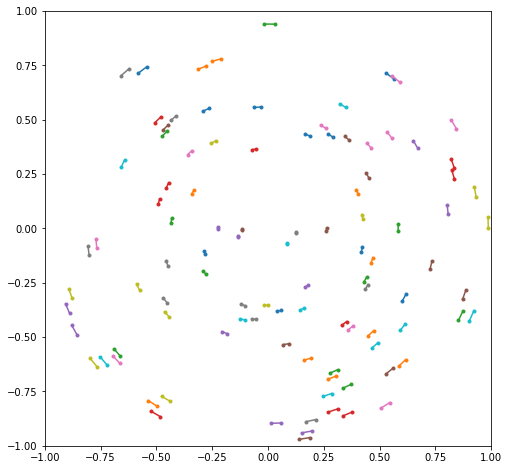

In [ ]:
fig, ax = generate_figure(figsize=(8,8), xlim=[-1, 1], ylim=[-1, 1])

for index, row in dac_data.iterrows():
    
    if index < 100:
        ax = plot_ode_solution(ax, row)
    else:
        break

plt.show()

## 4. Pytorch Datasets and Dataloaders

In [ ]:
class PINN_ODE_Dataset(Dataset):
    
    
    def __init__(self, pkl_file):
        
        self.data = self.read_pkl(pkl_file)
    
    
    def __len__(self):
        
        return len(self.data.index)
    
    
    def __getitem__(self, idx):
        
        item, label = self.data.iloc[idx]
        
        return item, label
    
    
    def read_pkl(self, pkl_file):
        
        with open(pkl_file, "rb") as f:
            return pickle.load(f)

In [ ]:
training_data_standard = PINN_ODE_Dataset(file_standard)

In [ ]:
training_data_standard = PINN_ODE_Dataset(file_standard)
train_dataloader_standard = DataLoader(training_data_standard, batch_size=64, shuffle=False)

#training_data_dac = PINN_ODE_Dataset(file_dac)
#train_dataloader_dac = DataLoader(training_data_dac, batch_size=64, shuffle=True)

In [ ]:
import random
import tqdm
from torch.autograd import Variable

## NAS

In [150]:
class MLPSearchSpace(object):
  def __init__(self):
      self.vocab = self.vocab_dict()
  def vocab_dict(self):
    #could be modified to contain cnn or more complicate structure
    nodes = [8,16,32,64,128,256,512,1024]
    act_funcs = ['relu','elu','tanh']

    layer_params = []
    layer_id = []

    for i in range(len(nodes)):
      for j in range(len(act_funcs)):
        layer_params.append((nodes[i],act_funcs[j]))
        layer_id.append(len(act_funcs)*i+j)
    vocab = dict(zip(layer_id,layer_params))
    #vocab[len(vocab)+1] = (('dropout'))

    #vocab[len(vocab)+1] = (2,'relu')
    return vocab

  def random_sample_architecture(self,architecture_num = 10):
    search_space_size = len(self.vocab)
    architecture_space = []
    for i in range(architecture_num):
      layer_num = random.randint(3, 10)
      sequence = [random.randint(0, search_space_size-1) for i in range(layer_num)]
      architecture_space.append(sequence)
    return architecture_space

  def encode_sequence(self, sequence):
    keys = list(self.vocab.keys())
    values = list(self.vocab.values())
    encoded_sequence = []
    for value in sequence:
      encoded_sequence.append(keys[values.index(value)])
    return encoded_sequence

  def decode_sequence(self, sequence):
    keys = list(self.vocab.keys())
    values = list(self.vocab.values())
    decoded_sequence = []
    for key in sequence:
      decoded_sequence.append(values[keys.index(key)])
    return decoded_sequence



In [122]:
mlpsearchspace = MLPSearchSpace()
vocab = mlpsearchspace.vocab_dict()
vocab

{0: (8, 'relu'),
 1: (8, 'elu'),
 2: (8, 'tanh'),
 3: (16, 'relu'),
 4: (16, 'elu'),
 5: (16, 'tanh'),
 6: (32, 'relu'),
 7: (32, 'elu'),
 8: (32, 'tanh'),
 9: (64, 'relu'),
 10: (64, 'elu'),
 11: (64, 'tanh'),
 12: (128, 'relu'),
 13: (128, 'elu'),
 14: (128, 'tanh'),
 15: (256, 'relu'),
 16: (256, 'elu'),
 17: (256, 'tanh'),
 18: (512, 'relu'),
 19: (512, 'elu'),
 20: (512, 'tanh'),
 21: (1024, 'relu'),
 22: (1024, 'elu'),
 23: (1024, 'tanh')}

In [123]:
mlpsearchspace.decode_sequence([2,3,4])

[(8, 'tanh'), (16, 'relu'), (16, 'elu')]

In [124]:
mlpsearchspace.random_sample_architecture()

[[21, 23, 7, 19, 4, 15, 2, 8],
 [7, 14, 15, 2, 23],
 [15, 8, 21, 23, 1, 22, 5, 12, 9],
 [18, 14, 16, 8, 13, 7, 23, 1],
 [17, 23, 20, 3, 22, 16, 13, 23, 2, 8],
 [17, 18, 8, 15, 14, 12],
 [21, 8, 5],
 [19, 10, 20, 3, 2, 1, 22, 23, 19],
 [17, 7, 11, 1, 23, 21],
 [12, 20, 3, 19, 4, 13, 22, 17, 9, 4]]

In [151]:
class MLPGenerator(MLPSearchSpace):
  def __init__(self):
    super().__init__()
    self.mlp_one_shot = True
    self.mlp_optimizer = 'Adam'
    self.mlp_lr = 1e-4
    self.mlp_loss_func = 'mse'

  def create_model(self,sequence,mlp_input_shape = 3):
    layer_configs = self.decode_sequence(sequence)
    #layer_configs = sequence
    layers = nn.Sequential()
    previous_layer_num = 0
    for i,layer_conf in enumerate(layer_configs):
      if i == 0:
        layers.append(nn.Linear(mlp_input_shape,layer_conf[0]))
        if layer_configs[i][1] == 'relu':
          layers.append(nn.ReLU())
        elif layer_configs[i][1] == 'elu':
          layers.append(nn.ELU())
        else:
          layers.append(nn.Tanh())
        previous_layer_num = layer_conf[0]
      else:
        layers.append(nn.Linear(previous_layer_num,layer_conf[0]))
        previous_layer_num = layer_conf[0]
        if layer_configs[1] == 'relu':
          layers.append(nn.ReLU())
        elif layer_configs[1] == 'elu':
          layers.append(nn.ELU())
        else:
          layers.append(nn.Tanh())
    layers.append(nn.Linear(previous_layer_num,2))
    return nn.Sequential(*layers)

  #low-fidelity training for one genertaed_sequence
  def train_model(self,model,train_dataloader = train_dataloader_standard):
    #decoded_sequence = self.decode_sequence(encoded_sequence)
    #model = self.create_model(encoded_sequence,3)
    #one shot training -- with only one epoch
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    model.train()
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
      # Get and prepare inputs
      inputs, targets = data
      inputs, targets = inputs.float(), targets.float()
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_function(outputs, targets)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    return running_loss

  #low-fidelity training for all generate_sequence
  def low_fidelity_evaluation(self,train_dataloader,sample_space):
    if not sample_space:
      search_space = self.random_sample_architecture()
    else:
      search_space = sample_space
    model_train_log = {}
    model_eval_log = {}
    architecture_history = {}
    for i,encoded_sequence in enumerate(search_space):
      print("training architecture: ", i)
      decoded_sequence = self.decode_sequence(encoded_sequence)
      model = self.create_model(encoded_sequence,3)
      #low fidelity training -- with only one epoch
      loss_function = nn.MSELoss()
      optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
      model.train()
      running_loss = 0.0
      for i, data in enumerate(train_dataloader, 0):
        # Get and prepare inputs
        inputs, targets = data
        inputs, targets = inputs.float(), targets.float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 199:
          print(f"batch {i + 1}] loss: {running_loss / 200:.3f}")
          running_loss = 0.0

      print("training loss: ",running_loss)
      model_train_log[f'{decoded_sequence}'] = running_loss
      architecture_history[f'{encoded_sequence}'] = running_loss
    return model_train_log,architecture_history

In [152]:
MAX_ARCHITECTURE_LENGTH = 5
class Controller_Model(nn.Module):
  def __init__(self,input_size,hidden_size,num_class,num_layers = 1):
    super().__init__()
    self.lstm = nn.LSTM(input_size,hidden_size,num_layers)
    self.sequence_generator = nn.Sequential(
        nn.Linear(hidden_size,256),
        nn.ReLU(),
        nn.Linear(256,num_class),
        nn.Softmax()
    )
  def forward(self,input):
    output,_ = self.lstm(input)
    generated_sequence = self.sequence_generator(output)
    return generated_sequence

class Controller(MLPSearchSpace):
  def __init__(self,max_architecture_length):
    super().__init__()
    self.max_length = max_architecture_length
    self.controller_classes = len(self.vocab)
    self.sequence_data = []

  def control_model(self):#controller_input_shape, controller_batch_size):
    #main_input = torch.Tensor()
    #
    model = Controller_Model(self.max_length,10,num_class = self.controller_classes)
    return model
  
  def train_control_model(self,model,x_data,y_data,loss_func,controller_training_epoch):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    #loss_func = torch.nn.CrossEntropyLoss()
    model.train()
    #print("Training Controller Model")
    for epoch in range(controller_training_epoch):
      print("Training Controller Model in epoch: ",epoch)
      optimizer.zero_grad()
      outputs = model(x_data)
      loss = loss_func(y_data,outputs)
      loss.sum().backward()
      optimizer.step()

  def sample_architrecture_sequences(self,model,number_of_samples,
                                     by_prob = True):
    samples = []
    print("Generate Architecture Samples...")
    print('--------------------------------')

    while len(samples) < number_of_samples:
      seed = []
      #number of layers we want in the architecture
      while len(seed) < self.max_length:
        seed_pad = np.pad(seed,pad_width=(0,self.max_length-len(seed)))
        sequence = torch.Tensor(seed_pad)
        sequence = sequence.reshape(1,len(sequence))
        logit = model(sequence)
        if by_prob == True:
          #sample next architecture code by the probabilities returned by controller model
          proba = logit.detach().numpy()[0]
          next = np.random.choice(list(self.vocab.keys()),size=1,p=proba).item()
        else:
          next = torch.argmax(logit).detach().item()
        seed.append(next)
      if seed not in self.sequence_data:
        samples.append(seed)
        self.sequence_data.append(seed)
    return samples

In [153]:
class MLPNAS(Controller):
  def __init__(self,max_architecture_length):
    super().__init__(max_architecture_length)
    self.model_generator = MLPGenerator()
    self.controller_model = self.control_model()
    self.controller_sampling_epochs = 3
    self.controller_loss_alpha = 0.9
    self.samples_per_controller_epoch = 10
    self.controller_training_epoch = 3
    self.data = []

  def append_model_metrics(self,sequence,history):
    self.data.append([sequence,history])

  #use REINFORCE to train controller
  def prepare_controller_data(self,sequences):
    def to_categorical(y, num_classes):
      return np.eye(num_classes, dtype='uint8')[y]
    x = torch.Tensor(sequences)[:,:-1].reshape(len(sequences),1,self.max_length-1)
    padding = torch.zeros([len(sequences),1,1])
    x_padded = torch.concat([x,padding],dim=2)
    y = torch.Tensor(sequences)[:,-1].type(torch.int64)
    y = to_categorical(y,self.controller_classes)

    val_loss_target = [item[1] for item in self.data[-self.samples_per_controller_epoch:]]
    return x_padded,y,val_loss_target

  def get_discounted_reward(self,rewards):
    discounted_r = np.zeros_like(rewards,dtype=np.float32)
    for t in range(len(rewards)):
      running_add = 0
      exp = 0
      for r in rewards[t:]:
        running_add += self.controller_loss_alpha**exp*r
        exp += 1
      discounted_r[t] = running_add
    discounted_r = (discounted_r - discounted_r.mean())/discounted_r.std()
    return discounted_r
  #need to be modified to give unbiased gradient estimate
  def custom_loss(self,target,output):
    reward = np.array([item[1] for item in self.data[-self.samples_per_controller_epoch:]]).reshape(self.samples_per_controller_epoch, 1)
    discounted_reward = self.get_discounted_reward(reward)
    output = torch.Tensor(output.detach().numpy())
    loss = -torch.log(output)*discounted_reward[:,None]
    loss = Variable(loss, requires_grad=True)
    return loss

  #if REINFORCE = False, the sequence is generated by LSTM controller but the controller does not learn
  def search(self,input_size,train_dataloader,REINFORCE = False):
    for controller_epoch in range(self.controller_sampling_epochs):
      sequences = self.sample_architrecture_sequences(self.controller_model,number_of_samples=self.samples_per_controller_epoch)
      print("Evaluating architectures in controller_sampling_epoch: ",controller_epoch)
      for i,sequence in enumerate(sequences):
        print("  training architecture: ",i)
        #train and log architecture
        decoded_sequence = self.model_generator.decode_sequence(sequence)
        model = self.model_generator.create_model(sequence,mlp_input_shape = input_size)
        history = self.model_generator.train_model(model,train_dataloader)
        self.append_model_metrics(decoded_sequence,history)

      if REINFORCE == True:
        if controller_epoch != self.controller_sampling_epochs - 1:
          print("Training Controller...")
          #train controller
          x,y,val_acc_target = self.prepare_controller_data(sequences)
          self.train_control_model(self.controller_model,x,y,self.custom_loss,self.controller_training_epoch)
      
    return self.data

#NAS experiments with standard appraoch

In [ ]:
mlpnas_reinforce_3_layers = MLPNAS(max_architecture_length = 3)
data_3_layers = mlpnas_reinforce_3_layers.search(REINFORCE=True)

Generate Architecture Samples...
--------------------------------
Evaluating architectures in controller_sampling_epoch:  0
  training architecture:  0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


  training architecture:  1
  training architecture:  2
  training architecture:  3
  training architecture:  4
  training architecture:  5
  training architecture:  6
  training architecture:  7
  training architecture:  8
  training architecture:  9
Training Controller...
Training Controller Model in epoch:  0
Training Controller Model in epoch:  1
Training Controller Model in epoch:  2
Generate Architecture Samples...
--------------------------------
Evaluating architectures in controller_sampling_epoch:  1
  training architecture:  0
  training architecture:  1
  training architecture:  2
  training architecture:  3
  training architecture:  4
  training architecture:  5
  training architecture:  6
  training architecture:  7
  training architecture:  8
  training architecture:  9
Training Controller...
Training Controller Model in epoch:  0
Training Controller Model in epoch:  1
Training Controller Model in epoch:  2
Generate Architecture Samples...
-------------------------------

In [ ]:
data_3_layers

[[[(16, 'elu'), (1024, 'tanh'), (16, 'elu')], 528.6388290434843],
 [[(256, 'relu'), (1024, 'tanh'), (8, 'relu')], 210.46762483159546],
 [[(16, 'tanh'), (64, 'relu'), (8, 'relu')], 853.1816860754916],
 [[(16, 'elu'), (1024, 'tanh'), (64, 'relu')], 450.43206625955645],
 [[(8, 'elu'), (128, 'elu'), (64, 'tanh')], 749.9869199758978],
 [[(512, 'tanh'), (512, 'tanh'), (32, 'relu')], 217.98009970094427],
 [[(16, 'tanh'), (64, 'relu'), (128, 'tanh')], 705.4671777348849],
 [[(1024, 'tanh'), (128, 'elu'), (1024, 'tanh')], 180.66237260150956],
 [[(512, 'elu'), (64, 'relu'), (512, 'elu')], 249.23538866604213],
 [[(512, 'tanh'), (32, 'relu'), (128, 'tanh')], 367.4367097161594],
 [[(32, 'tanh'), (64, 'elu'), (64, 'relu')], 700.2548199284356],
 [[(1024, 'tanh'), (8, 'elu'), (512, 'relu')], 264.40249063714873],
 [[(256, 'relu'), (16, 'elu'), (1024, 'relu')], 282.1016974285885],
 [[(256, 'elu'), (512, 'elu'), (32, 'tanh')], 272.2006626101793],
 [[(128, 'relu'), (64, 'relu'), (128, 'elu')], 420.62485268

In [ ]:
encoded_sequence = mlpnas_reinforce_3_layers.encode_sequence([(1024, 'relu'), (1024, 'relu'), (64, 'elu')])
#[(1024, 'relu'), (1024, 'relu'), (64, 'elu')]
mlpnas_best_model_3_layer = mlpnas_reinforce_3_layers.model_generator.create_model(encoded_sequence)
mlpnas_best_model_3_layer

Sequential(
  (0): Linear(in_features=3, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=1024, bias=True)
  (3): Tanh()
  (4): Linear(in_features=1024, out_features=64, bias=True)
  (5): Tanh()
  (6): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
mlpnas_reinforce_5_layers = MLPNAS(max_architecture_length = 5)
data_5_layers = mlpnas_reinforce_5_layers.search(REINFORCE=True)

Generate Architecture Samples...
--------------------------------
Evaluating architectures in controller_sampling_epoch:  0
  training architecture:  0
  training architecture:  1
  training architecture:  2
  training architecture:  3
  training architecture:  4
  training architecture:  5
  training architecture:  6
  training architecture:  7
  training architecture:  8
  training architecture:  9
Training Controller...
Training Controller Model in epoch:  0
Training Controller Model in epoch:  1
Training Controller Model in epoch:  2
Generate Architecture Samples...
--------------------------------
Evaluating architectures in controller_sampling_epoch:  1
  training architecture:  0
  training architecture:  1
  training architecture:  2
  training architecture:  3
  training architecture:  4
  training architecture:  5
  training architecture:  6
  training architecture:  7
  training architecture:  8
  training architecture:  9
Training Controller...
Training Controller Model in 

In [ ]:
data_5_layers

[[[(64, 'elu'), (64, 'elu'), (16, 'relu'), (32, 'relu'), (128, 'elu')],
  702.2166351427586],
 [[(1024, 'tanh'), (64, 'tanh'), (256, 'elu'), (64, 'relu'), (256, 'elu')],
  166.65878961226554],
 [[(32, 'elu'), (32, 'relu'), (256, 'tanh'), (1024, 'elu'), (1024, 'relu')],
  437.35448838805314],
 [[(1024, 'tanh'), (64, 'tanh'), (256, 'elu'), (256, 'tanh'), (256, 'relu')],
  180.57269421039382],
 [[(8, 'relu'), (64, 'relu'), (16, 'tanh'), (64, 'tanh'), (512, 'elu')],
  675.6204619960627],
 [[(32, 'tanh'), (16, 'relu'), (1024, 'relu'), (8, 'elu'), (32, 'elu')],
  588.084463751642],
 [[(32, 'relu'), (32, 'tanh'), (1024, 'elu'), (8, 'relu'), (64, 'tanh')],
  456.25991555768996],
 [[(1024, 'relu'), (1024, 'tanh'), (64, 'elu'), (16, 'tanh'), (8, 'elu')],
  150.16571553889662],
 [[(64, 'relu'), (8, 'elu'), (8, 'elu'), (256, 'tanh'), (8, 'elu')],
  716.6711944969138],
 [[(8, 'tanh'), (512, 'relu'), (256, 'tanh'), (32, 'relu'), (1024, 'tanh')],
  492.0019340146682],
 [[(32, 'relu'), (512, 'relu'), 

In [ ]:
encoded_sequence = mlpnas_reinforce_5_layers.encode_sequence([(1024, 'relu'), (512, 'relu'), (8, 'tanh'), (256, 'relu'), (64, 'relu')])
mlpnas_best_model_5_layer = mlpnas_reinforce_5_layers.model_generator.create_model(encoded_sequence)
mlpnas_best_model_5_layer

Sequential(
  (0): Linear(in_features=3, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): Tanh()
  (4): Linear(in_features=512, out_features=8, bias=True)
  (5): Tanh()
  (6): Linear(in_features=8, out_features=256, bias=True)
  (7): Tanh()
  (8): Linear(in_features=256, out_features=64, bias=True)
  (9): Tanh()
  (10): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
train(mlpnas_best_model_3_layer, train_dataloader_standard, 3)

Starting epoch 1...
[epoch 1, batch 200] loss: 0.181
[epoch 1, batch 400] loss: 0.089
[epoch 1, batch 600] loss: 0.057
[epoch 1, batch 800] loss: 0.040
[epoch 1, batch 1000] loss: 0.031
[epoch 1, batch 1200] loss: 0.028
[epoch 1, batch 1400] loss: 0.037
[epoch 1, batch 1600] loss: 0.019
[epoch 1, batch 1800] loss: 0.014
[epoch 1, batch 2000] loss: 0.013
[epoch 1, batch 2200] loss: 0.018
[epoch 1, batch 2400] loss: 0.013
[epoch 1, batch 2600] loss: 0.011
[epoch 1, batch 2800] loss: 0.007
[epoch 1, batch 3000] loss: 0.010
[epoch 1, batch 3200] loss: 0.012
[epoch 1, batch 3400] loss: 0.008
[epoch 1, batch 3600] loss: 0.009
Starting epoch 2...
[epoch 2, batch 200] loss: 0.009
[epoch 2, batch 400] loss: 0.008
[epoch 2, batch 600] loss: 0.009
[epoch 2, batch 800] loss: 0.006
[epoch 2, batch 1000] loss: 0.006
[epoch 2, batch 1200] loss: 0.011
[epoch 2, batch 1400] loss: 0.005
[epoch 2, batch 1600] loss: 0.006
[epoch 2, batch 1800] loss: 0.004
[epoch 2, batch 2000] loss: 0.005
[epoch 2, batch 

In [ ]:
train(mlpnas_best_model_5_layer, train_dataloader_standard, 3)

Starting epoch 1...
[epoch 1, batch 200] loss: 0.212
[epoch 1, batch 400] loss: 0.095
[epoch 1, batch 600] loss: 0.050
[epoch 1, batch 800] loss: 0.033
[epoch 1, batch 1000] loss: 0.027
[epoch 1, batch 1200] loss: 0.019
[epoch 1, batch 1400] loss: 0.030
[epoch 1, batch 1600] loss: 0.014
[epoch 1, batch 1800] loss: 0.013
[epoch 1, batch 2000] loss: 0.019
[epoch 1, batch 2200] loss: 0.016
[epoch 1, batch 2400] loss: 0.013
[epoch 1, batch 2600] loss: 0.008
[epoch 1, batch 2800] loss: 0.009
[epoch 1, batch 3000] loss: 0.014
[epoch 1, batch 3200] loss: 0.008
[epoch 1, batch 3400] loss: 0.008
[epoch 1, batch 3600] loss: 0.006
Starting epoch 2...
[epoch 2, batch 200] loss: 0.011
[epoch 2, batch 400] loss: 0.007
[epoch 2, batch 600] loss: 0.008
[epoch 2, batch 800] loss: 0.013
[epoch 2, batch 1000] loss: 0.007
[epoch 2, batch 1200] loss: 0.011
[epoch 2, batch 1400] loss: 0.010
[epoch 2, batch 1600] loss: 0.005
[epoch 2, batch 1800] loss: 0.005
[epoch 2, batch 2000] loss: 0.010
[epoch 2, batch 

In [ ]:
y0 = np.array([0.5, 0])
delta_t = 0.1
tstar = 0.1
max_t_prediction = 20

validation_standard = predict_standard(standard_model, y0, delta_t, max_t_prediction)
validation_nas_3 = predict_standard(mlpnas_best_model_3_layer, y0, delta_t, max_t_prediction)
validation_nas_5 = predict_standard(mlpnas_best_model_5_layer, y0, delta_t, max_t_prediction)
#validation_dac = predict_dac(dac_model, y0, tstar, max_t_prediction)

times = np.arange(0, max_t_prediction, delta_t)
true_solution = [solution_simple_ODE(t, y0) for t in times]

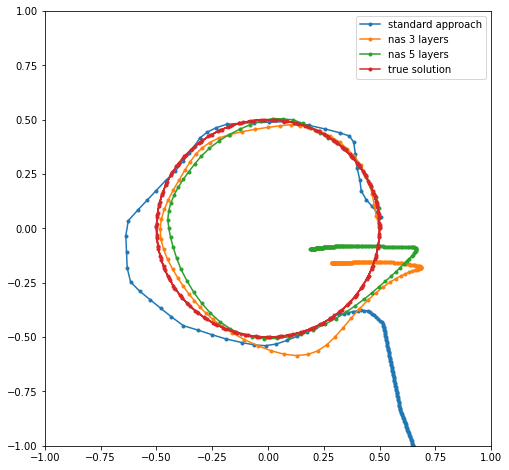

In [ ]:
fig, ax = generate_figure(figsize=(8,8), xlim=[-1, 1], ylim=[-1, 1])

ax = plot_ode_solution(ax, validation_standard, label="standard approach")
ax = plot_ode_solution(ax, validation_nas_3, label="nas 3 layers")
ax = plot_ode_solution(ax, validation_nas_5, label="nas 5 layers")
ax = plot_ode_solution(ax, true_solution, label="true solution")

plt.legend()
plt.savefig("proof_of_concept.pdf", bbox_inches="tight")
plt.show()

In [ ]:
#train with less epoch
encoded_sequence = mlpnas_reinforce_3_layers.encode_sequence([(1024, 'relu'), (1024, 'relu'), (64, 'elu')])
mlpnas_best_model_3_layer = mlpnas_reinforce_3_layers.model_generator.create_model(encoded_sequence)
train(mlpnas_best_model_3_layer, train_dataloader_standard, 2)

Starting epoch 1...
[epoch 1, batch 200] loss: 0.177
[epoch 1, batch 400] loss: 0.086
[epoch 1, batch 600] loss: 0.055
[epoch 1, batch 800] loss: 0.038
[epoch 1, batch 1000] loss: 0.038
[epoch 1, batch 1200] loss: 0.031
[epoch 1, batch 1400] loss: 0.022
[epoch 1, batch 1600] loss: 0.019
[epoch 1, batch 1800] loss: 0.016
[epoch 1, batch 2000] loss: 0.017
[epoch 1, batch 2200] loss: 0.012
[epoch 1, batch 2400] loss: 0.013
[epoch 1, batch 2600] loss: 0.008
[epoch 1, batch 2800] loss: 0.007
[epoch 1, batch 3000] loss: 0.010
[epoch 1, batch 3200] loss: 0.009
[epoch 1, batch 3400] loss: 0.007
[epoch 1, batch 3600] loss: 0.010
Starting epoch 2...
[epoch 2, batch 200] loss: 0.008
[epoch 2, batch 400] loss: 0.026
[epoch 2, batch 600] loss: 0.006
[epoch 2, batch 800] loss: 0.003
[epoch 2, batch 1000] loss: 0.003
[epoch 2, batch 1200] loss: 0.009
[epoch 2, batch 1400] loss: 0.006
[epoch 2, batch 1600] loss: 0.003
[epoch 2, batch 1800] loss: 0.004
[epoch 2, batch 2000] loss: 0.008
[epoch 2, batch 

In [ ]:
encoded_sequence = mlpnas_reinforce_5_layers.encode_sequence([(1024, 'relu'), (512, 'relu'), (8, 'tanh'), (256, 'relu'), (64, 'relu')])
mlpnas_best_model_5_layer = mlpnas_reinforce_5_layers.model_generator.create_model(encoded_sequence)
train(mlpnas_best_model_5_layer, train_dataloader_standard, 2)

Starting epoch 1...
[epoch 1, batch 200] loss: 0.207
[epoch 1, batch 400] loss: 0.087
[epoch 1, batch 600] loss: 0.047
[epoch 1, batch 800] loss: 0.034
[epoch 1, batch 1000] loss: 0.025
[epoch 1, batch 1200] loss: 0.021
[epoch 1, batch 1400] loss: 0.025
[epoch 1, batch 1600] loss: 0.022
[epoch 1, batch 1800] loss: 0.020
[epoch 1, batch 2000] loss: 0.014
[epoch 1, batch 2200] loss: 0.016
[epoch 1, batch 2400] loss: 0.011
[epoch 1, batch 2600] loss: 0.009
[epoch 1, batch 2800] loss: 0.006
[epoch 1, batch 3000] loss: 0.012
[epoch 1, batch 3200] loss: 0.007
[epoch 1, batch 3400] loss: 0.009
[epoch 1, batch 3600] loss: 0.011
Starting epoch 2...
[epoch 2, batch 200] loss: 0.009
[epoch 2, batch 400] loss: 0.012
[epoch 2, batch 600] loss: 0.011
[epoch 2, batch 800] loss: 0.006
[epoch 2, batch 1000] loss: 0.005
[epoch 2, batch 1200] loss: 0.008
[epoch 2, batch 1400] loss: 0.011
[epoch 2, batch 1600] loss: 0.005
[epoch 2, batch 1800] loss: 0.007
[epoch 2, batch 2000] loss: 0.012
[epoch 2, batch 

In [ ]:
standard_model = MLP_Standard()
train(standard_model, train_dataloader_standard, 2)

Starting epoch 1...
[epoch 1, batch 200] loss: 0.250
[epoch 1, batch 400] loss: 0.224
[epoch 1, batch 600] loss: 0.232
[epoch 1, batch 800] loss: 0.249
[epoch 1, batch 1000] loss: 0.228
[epoch 1, batch 1200] loss: 0.216
[epoch 1, batch 1400] loss: 0.216
[epoch 1, batch 1600] loss: 0.188
[epoch 1, batch 1800] loss: 0.169
[epoch 1, batch 2000] loss: 0.154
[epoch 1, batch 2200] loss: 0.155
[epoch 1, batch 2400] loss: 0.122
[epoch 1, batch 2600] loss: 0.104
[epoch 1, batch 2800] loss: 0.082
[epoch 1, batch 3000] loss: 0.082
[epoch 1, batch 3200] loss: 0.075
[epoch 1, batch 3400] loss: 0.067
[epoch 1, batch 3600] loss: 0.061
Starting epoch 2...
[epoch 2, batch 200] loss: 0.052
[epoch 2, batch 400] loss: 0.044
[epoch 2, batch 600] loss: 0.042
[epoch 2, batch 800] loss: 0.040
[epoch 2, batch 1000] loss: 0.035
[epoch 2, batch 1200] loss: 0.033
[epoch 2, batch 1400] loss: 0.033
[epoch 2, batch 1600] loss: 0.027
[epoch 2, batch 1800] loss: 0.025
[epoch 2, batch 2000] loss: 0.025
[epoch 2, batch 

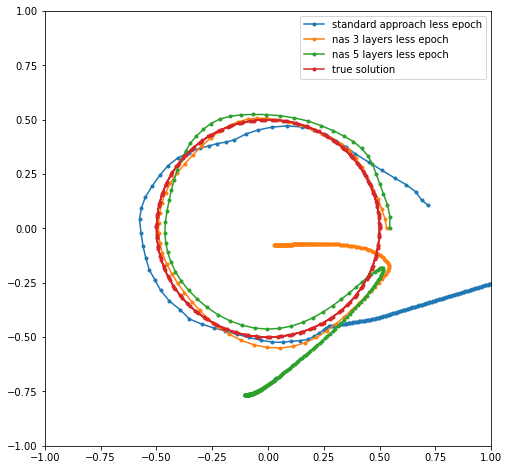

In [ ]:
y0 = np.array([0.5, 0])
delta_t = 0.1
tstar = 0.1
max_t_prediction = 20

validation_standard = predict_standard(standard_model, y0, delta_t, max_t_prediction)
validation_nas_3 = predict_standard(mlpnas_best_model_3_layer, y0, delta_t, max_t_prediction)
validation_nas_5 = predict_standard(mlpnas_best_model_5_layer, y0, delta_t, max_t_prediction)
#validation_dac = predict_dac(dac_model, y0, tstar, max_t_prediction)

times = np.arange(0, max_t_prediction, delta_t)
true_solution = [solution_simple_ODE(t, y0) for t in times]

fig, ax = generate_figure(figsize=(8,8), xlim=[-1, 1], ylim=[-1, 1])

ax = plot_ode_solution(ax, validation_standard, label="standard approach less epoch")
ax = plot_ode_solution(ax, validation_nas_3, label="nas 3 layers less epoch")
ax = plot_ode_solution(ax, validation_nas_5, label="nas 5 layers less epoch")
ax = plot_ode_solution(ax, true_solution, label="true solution")

plt.legend()
plt.savefig("proof_of_concept.pdf", bbox_inches="tight")
plt.show()

In [ ]:
encoded_sequence = mlpnas_reinforce_3_layers.encode_sequence([(1024, 'relu'), (1024, 'relu'), (64, 'elu')])
mlpnas_best_model_3_layer = mlpnas_reinforce_3_layers.model_generator.create_model(encoded_sequence)
train(mlpnas_best_model_3_layer, train_dataloader_standard, 3)
encoded_sequence = mlpnas_reinforce_5_layers.encode_sequence([(1024, 'relu'), (512, 'relu'), (8, 'tanh'), (256, 'relu'), (64, 'relu')])
mlpnas_best_model_5_layer = mlpnas_reinforce_5_layers.model_generator.create_model(encoded_sequence)
train(mlpnas_best_model_5_layer, train_dataloader_standard, 3)
standard_model = MLP_Standard()
train(standard_model, train_dataloader_standard, 3)

Starting epoch 1...
[epoch 1, batch 200] loss: 0.181
[epoch 1, batch 400] loss: 0.091
[epoch 1, batch 600] loss: 0.058
[epoch 1, batch 800] loss: 0.041
[epoch 1, batch 1000] loss: 0.034
[epoch 1, batch 1200] loss: 0.035
[epoch 1, batch 1400] loss: 0.029
[epoch 1, batch 1600] loss: 0.027
[epoch 1, batch 1800] loss: 0.020
[epoch 1, batch 2000] loss: 0.019
[epoch 1, batch 2200] loss: 0.012
[epoch 1, batch 2400] loss: 0.013
[epoch 1, batch 2600] loss: 0.010
[epoch 1, batch 2800] loss: 0.008
[epoch 1, batch 3000] loss: 0.010
[epoch 1, batch 3200] loss: 0.010
[epoch 1, batch 3400] loss: 0.011
[epoch 1, batch 3600] loss: 0.011
Starting epoch 2...
[epoch 2, batch 200] loss: 0.009
[epoch 2, batch 400] loss: 0.008
[epoch 2, batch 600] loss: 0.007
[epoch 2, batch 800] loss: 0.005
[epoch 2, batch 1000] loss: 0.007
[epoch 2, batch 1200] loss: 0.006
[epoch 2, batch 1400] loss: 0.007
[epoch 2, batch 1600] loss: 0.009
[epoch 2, batch 1800] loss: 0.006
[epoch 2, batch 2000] loss: 0.008
[epoch 2, batch 

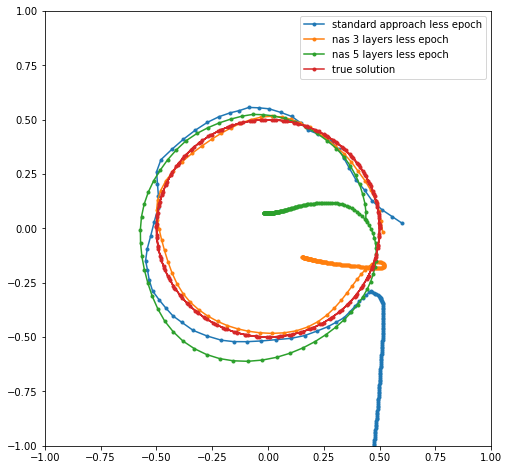

In [ ]:
y0 = np.array([0.5, 0])
delta_t = 0.1
tstar = 0.1
max_t_prediction = 20

validation_standard = predict_standard(standard_model, y0, delta_t, max_t_prediction)
validation_nas_3 = predict_standard(mlpnas_best_model_3_layer, y0, delta_t, max_t_prediction)
validation_nas_5 = predict_standard(mlpnas_best_model_5_layer, y0, delta_t, max_t_prediction)
#validation_dac = predict_dac(dac_model, y0, tstar, max_t_prediction)

times = np.arange(0, max_t_prediction, delta_t)
true_solution = [solution_simple_ODE(t, y0) for t in times]

fig, ax = generate_figure(figsize=(8,8), xlim=[-1, 1], ylim=[-1, 1])

ax = plot_ode_solution(ax, validation_standard, label="standard approach less epoch")
ax = plot_ode_solution(ax, validation_nas_3, label="nas 3 layers less epoch")
ax = plot_ode_solution(ax, validation_nas_5, label="nas 5 layers less epoch")
ax = plot_ode_solution(ax, true_solution, label="true solution")

plt.legend()
plt.savefig("proof_of_concept.pdf", bbox_inches="tight")
plt.show()

In [ ]:
print("nas REINFORCE 3 layers euclidean distance: ",compute_euclidean_distance(true_solution,validation_nas_3))
print("nas REINFORCE 5 layers euclidean distance: ",compute_euclidean_distance(true_solution,validation_nas_5))
print("standard approach euclidean distance: ",compute_euclidean_distance(true_solution,validation_standard))

nas REINFORCE 3 layers euclidean distance:  52.26485578580248
nas REINFORCE 5 layers euclidean distance:  38.32308038292433
standard approach euclidean distance:  160.23484745969884


In [ ]:
#compare random search with REINFORCE search and true solution
mlpnas_reinforce_3_layers = MLPNAS(max_architecture_length = 3)
samples = mlpnas_reinforce_3_layers.model_generator.random_sample_architecture()
model_train_log,architecture_history = mlpnas_reinforce_3_layers.model_generator.low_fidelity_evaluation(train_dataloader_standard,samples)

training architecture:  0
batch 200] loss: 0.251
batch 400] loss: 0.229
batch 600] loss: 0.240
batch 800] loss: 0.244
batch 1000] loss: 0.195
batch 1200] loss: 0.189
batch 1400] loss: 0.176
batch 1600] loss: 0.136
batch 1800] loss: 0.115
batch 2000] loss: 0.103
batch 2200] loss: 0.099
batch 2400] loss: 0.073
batch 2600] loss: 0.067
batch 2800] loss: 0.055
batch 3000] loss: 0.062
batch 3200] loss: 0.064
batch 3400] loss: 0.058
batch 3600] loss: 0.059
training loss:  8.214782922528684
training architecture:  1
batch 200] loss: 0.248
batch 400] loss: 0.205
batch 600] loss: 0.187
batch 800] loss: 0.166
batch 1000] loss: 0.121
batch 1200] loss: 0.072
batch 1400] loss: 0.043
batch 1600] loss: 0.021
batch 1800] loss: 0.017
batch 2000] loss: 0.017
batch 2200] loss: 0.014
batch 2400] loss: 0.010
batch 2600] loss: 0.009
batch 2800] loss: 0.007
batch 3000] loss: 0.008
batch 3200] loss: 0.008
batch 3400] loss: 0.006
batch 3600] loss: 0.005
training loss:  0.9022649559774436
training architecture: 

In [ ]:
encoded_sequence = mlpnas_reinforce_3_layers.encode_sequence([(64, 'elu'), (256, 'relu'), (512, 'relu'), (128, 'relu'), (128, 'tanh'), (1024, 'elu'), (8, 'elu'), (8, 'tanh'), (64, 'relu'), (256, 'elu')])
mlpnas_best_model_random_search = mlpnas_reinforce_3_layers.model_generator.create_model(encoded_sequence)
train(mlpnas_best_model_random_search, train_dataloader_standard, 2)

Starting epoch 1...
[epoch 1, batch 200] loss: 0.249
[epoch 1, batch 400] loss: 0.217
[epoch 1, batch 600] loss: 0.202
[epoch 1, batch 800] loss: 0.217
[epoch 1, batch 1000] loss: 0.189
[epoch 1, batch 1200] loss: 0.153
[epoch 1, batch 1400] loss: 0.153
[epoch 1, batch 1600] loss: 0.112
[epoch 1, batch 1800] loss: 0.096
[epoch 1, batch 2000] loss: 0.079
[epoch 1, batch 2200] loss: 0.081
[epoch 1, batch 2400] loss: 0.044
[epoch 1, batch 2600] loss: 0.035
[epoch 1, batch 2800] loss: 0.027
[epoch 1, batch 3000] loss: 0.033
[epoch 1, batch 3200] loss: 0.025
[epoch 1, batch 3400] loss: 0.018
[epoch 1, batch 3600] loss: 0.020
Starting epoch 2...
[epoch 2, batch 200] loss: 0.012
[epoch 2, batch 400] loss: 0.016
[epoch 2, batch 600] loss: 0.013
[epoch 2, batch 800] loss: 0.013
[epoch 2, batch 1000] loss: 0.008
[epoch 2, batch 1200] loss: 0.009
[epoch 2, batch 1400] loss: 0.010
[epoch 2, batch 1600] loss: 0.006
[epoch 2, batch 1800] loss: 0.009
[epoch 2, batch 2000] loss: 0.010
[epoch 2, batch 

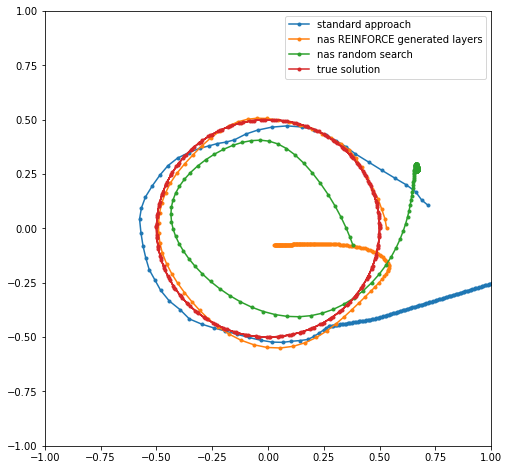

In [ ]:
y0 = np.array([0.5, 0])
delta_t = 0.1
tstar = 0.1
max_t_prediction = 20

validation_standard = predict_standard(standard_model, y0, delta_t, max_t_prediction)
validation_nas_3 = predict_standard(mlpnas_best_model_3_layer, y0, delta_t, max_t_prediction)
validation_nas_5 = predict_standard(mlpnas_best_model_random_search, y0, delta_t, max_t_prediction)
#validation_dac = predict_dac(dac_model, y0, tstar, max_t_prediction)

times = np.arange(0, max_t_prediction, delta_t)
true_solution = [solution_simple_ODE(t, y0) for t in times]

fig, ax = generate_figure(figsize=(8,8), xlim=[-1, 1], ylim=[-1, 1])

ax = plot_ode_solution(ax, validation_standard, label="standard approach ")
ax = plot_ode_solution(ax, validation_nas_3, label="nas REINFORCE generated layers")
ax = plot_ode_solution(ax, validation_nas_5, label="nas random search")
ax = plot_ode_solution(ax, true_solution, label="true solution")

plt.legend()
plt.savefig("proof_of_concept.pdf", bbox_inches="tight")
plt.show()

In [167]:
def compute_euclidean_distance(target,output):
  euclidean_distance = 0
  for i in range(len(target)):
    euclidean_distance += (target[i][0]-output[i][0])**2 + (target[i][1]-output[i][1])**2
  return (euclidean_distance)**0.5

In [ ]:
print("nas REINFORCE euclidean distance: ",compute_euclidean_distance(true_solution,validation_nas_3))
print("nas random search euclidean distance: ",compute_euclidean_distance(true_solution,validation_nas_5))
print("standard approach euclidean distance: ",compute_euclidean_distance(true_solution,validation_standard))

nas REINFORCE euclidean distance:  45.92026582895431
nas random search euclidean distance:  101.55929987775104
standard approach euclidean distance:  131.36369901850185


In [4]:
x = 166
x**0.5

12.884098726725126

# NAS Experiments with DAC approach

In [ ]:
training_data_dac = PINN_ODE_Dataset(file_dac)
train_dataloader_dac = DataLoader(training_data_dac, batch_size=64, shuffle=True)

In [ ]:
dac_mlpnas_reinforce_3_layers = MLPNAS(max_architecture_length = 3)
encoded_sequence = dac_mlpnas_reinforce_3_layers.encode_sequence([(1024, 'relu'), (1024, 'relu'), (64, 'elu')])
mlpnas_best_model_3_layer_dac = mlpnas_reinforce_3_layers.model_generator.create_model(encoded_sequence,2)
mlpnas_best_model_3_layer_dac

Sequential(
  (0): Linear(in_features=2, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=1024, bias=True)
  (3): Tanh()
  (4): Linear(in_features=1024, out_features=64, bias=True)
  (5): Tanh()
  (6): Linear(in_features=64, out_features=2, bias=True)
)

In [119]:
dac_mlpnas_reinforce_5_layers = MLPNAS(max_architecture_length = 5)
encoded_sequence = dac_mlpnas_reinforce_5_layers.encode_sequence([(1024, 'relu'), (512, 'relu'), (8, 'tanh'), (256, 'relu'), (64, 'relu')])
mlpnas_best_model_5_layer_dac = dac_mlpnas_reinforce_5_layers.model_generator.create_model(encoded_sequence,2)
mlpnas_best_model_5_layer_dac

Sequential(
  (0): Linear(in_features=2, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): Tanh()
  (4): Linear(in_features=512, out_features=8, bias=True)
  (5): Tanh()
  (6): Linear(in_features=8, out_features=256, bias=True)
  (7): Tanh()
  (8): Linear(in_features=256, out_features=64, bias=True)
  (9): Tanh()
  (10): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
train(mlpnas_best_model_3_layer_dac, train_dataloader_dac, 3)

Starting epoch 1...
[epoch 1, batch 200] loss: 0.005
[epoch 1, batch 400] loss: 0.000
[epoch 1, batch 600] loss: 0.000
[epoch 1, batch 800] loss: 0.000
[epoch 1, batch 1000] loss: 0.000
[epoch 1, batch 1200] loss: 0.000
[epoch 1, batch 1400] loss: 0.000
[epoch 1, batch 1600] loss: 0.000
[epoch 1, batch 1800] loss: 0.000
[epoch 1, batch 2000] loss: 0.000
[epoch 1, batch 2200] loss: 0.000
[epoch 1, batch 2400] loss: 0.000
[epoch 1, batch 2600] loss: 0.000
[epoch 1, batch 2800] loss: 0.000
[epoch 1, batch 3000] loss: 0.000
[epoch 1, batch 3200] loss: 0.000
[epoch 1, batch 3400] loss: 0.000
[epoch 1, batch 3600] loss: 0.000
Starting epoch 2...
[epoch 2, batch 200] loss: 0.000
[epoch 2, batch 400] loss: 0.000
[epoch 2, batch 600] loss: 0.000
[epoch 2, batch 800] loss: 0.000
[epoch 2, batch 1000] loss: 0.000
[epoch 2, batch 1200] loss: 0.000
[epoch 2, batch 1400] loss: 0.000
[epoch 2, batch 1600] loss: 0.000
[epoch 2, batch 1800] loss: 0.000
[epoch 2, batch 2000] loss: 0.000
[epoch 2, batch 

In [120]:
train(mlpnas_best_model_5_layer_dac, train_dataloader_dac, 3)

Starting epoch 1...
[epoch 1, batch 200] loss: 0.020
[epoch 1, batch 400] loss: 0.000
[epoch 1, batch 600] loss: 0.000
[epoch 1, batch 800] loss: 0.000
[epoch 1, batch 1000] loss: 0.000
[epoch 1, batch 1200] loss: 0.000
[epoch 1, batch 1400] loss: 0.000
[epoch 1, batch 1600] loss: 0.000
[epoch 1, batch 1800] loss: 0.000
[epoch 1, batch 2000] loss: 0.000
[epoch 1, batch 2200] loss: 0.000
[epoch 1, batch 2400] loss: 0.000
[epoch 1, batch 2600] loss: 0.000
[epoch 1, batch 2800] loss: 0.000
[epoch 1, batch 3000] loss: 0.000
[epoch 1, batch 3200] loss: 0.000
[epoch 1, batch 3400] loss: 0.000
[epoch 1, batch 3600] loss: 0.000
Starting epoch 2...
[epoch 2, batch 200] loss: 0.000
[epoch 2, batch 400] loss: 0.000
[epoch 2, batch 600] loss: 0.000
[epoch 2, batch 800] loss: 0.000
[epoch 2, batch 1000] loss: 0.000
[epoch 2, batch 1200] loss: 0.000
[epoch 2, batch 1400] loss: 0.000
[epoch 2, batch 1600] loss: 0.000
[epoch 2, batch 1800] loss: 0.000
[epoch 2, batch 2000] loss: 0.000
[epoch 2, batch 

In [128]:
dac_model = MLP_DAC()
train(dac_model, train_dataloader_dac, 3)

Starting epoch 1...
[epoch 1, batch 200] loss: 0.202
[epoch 1, batch 400] loss: 0.045
[epoch 1, batch 600] loss: 0.001
[epoch 1, batch 800] loss: 0.000
[epoch 1, batch 1000] loss: 0.000
[epoch 1, batch 1200] loss: 0.000
[epoch 1, batch 1400] loss: 0.000
[epoch 1, batch 1600] loss: 0.000
[epoch 1, batch 1800] loss: 0.000
[epoch 1, batch 2000] loss: 0.000
[epoch 1, batch 2200] loss: 0.000
[epoch 1, batch 2400] loss: 0.000
[epoch 1, batch 2600] loss: 0.000
[epoch 1, batch 2800] loss: 0.000
[epoch 1, batch 3000] loss: 0.000
[epoch 1, batch 3200] loss: 0.000
[epoch 1, batch 3400] loss: 0.000
[epoch 1, batch 3600] loss: 0.000
Starting epoch 2...
[epoch 2, batch 200] loss: 0.000
[epoch 2, batch 400] loss: 0.000
[epoch 2, batch 600] loss: 0.000
[epoch 2, batch 800] loss: 0.000
[epoch 2, batch 1000] loss: 0.000
[epoch 2, batch 1200] loss: 0.000
[epoch 2, batch 1400] loss: 0.000
[epoch 2, batch 1600] loss: 0.000
[epoch 2, batch 1800] loss: 0.000
[epoch 2, batch 2000] loss: 0.000
[epoch 2, batch 

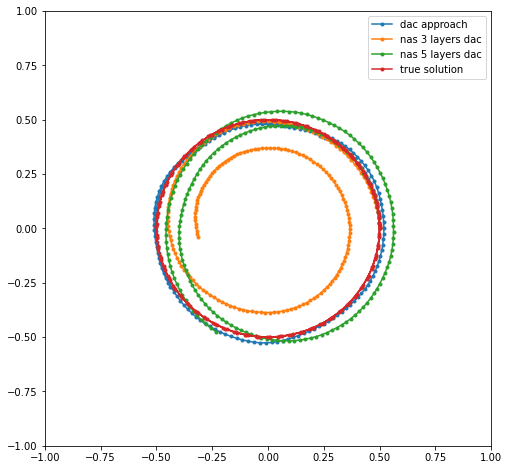

In [130]:
y0 = np.array([0.5, 0])
delta_t = 0.1
tstar = 0.1
max_t_prediction = 20

validation_dac = predict_dac(dac_model, y0, tstar, max_t_prediction)
validation_nas_3_dac = predict_dac(mlpnas_best_model_3_layer_dac, y0, tstar, max_t_prediction)
validation_nas_5_dac = predict_dac(mlpnas_best_model_5_layer_dac, y0, tstar, max_t_prediction)
#validation_dac = predict_dac(dac_model, y0, tstar, max_t_prediction)

times = np.arange(0, max_t_prediction, delta_t)
true_solution = [solution_simple_ODE(t, y0) for t in times]

fig, ax = generate_figure(figsize=(8,8), xlim=[-1, 1], ylim=[-1, 1])

ax = plot_ode_solution(ax, validation_dac, label="dac approach")
ax = plot_ode_solution(ax, validation_nas_3_dac, label="nas 3 layers dac")
ax = plot_ode_solution(ax, validation_nas_5_dac, label="nas 5 layers dac")
ax = plot_ode_solution(ax, true_solution, label="true solution")

plt.legend()
plt.savefig("proof_of_concept.pdf", bbox_inches="tight")
plt.show()

In [132]:
print("nas REINFORCE 3 layer euclidean distance: ",compute_euclidean_distance(true_solution,validation_nas_3_dac))
print("nas REINFORCE 3 layer euclidean distance: ",compute_euclidean_distance(true_solution,validation_nas_5_dac))
print("DAC approach euclidean distance: ",compute_euclidean_distance(true_solution,validation_dac))

nas REINFORCE 3 layer euclidean distance:  88.55172295573541
nas REINFORCE 3 layer euclidean distance:  99.57598349354936
DAC approach euclidean distance:  105.40198504164438


In [139]:
#train with less epoch
mlpnas_best_model_3_layer_dac = mlpnas_reinforce_3_layers.model_generator.create_model(encoded_sequence,2)
#mlpnas_best_model_3_layer_dac
mlpnas_best_model_5_layer_dac = mlpnas_reinforce_5_layers.model_generator.create_model(encoded_sequence,2)
dac_model = MLP_DAC()
train(mlpnas_best_model_3_layer_dac, train_dataloader_dac, 3)
train(mlpnas_best_model_5_layer_dac, train_dataloader_dac, 3)
train(dac_model, train_dataloader_dac, 3)

Starting epoch 1...
[epoch 1, batch 200] loss: 0.017
[epoch 1, batch 400] loss: 0.000
[epoch 1, batch 600] loss: 0.000
[epoch 1, batch 800] loss: 0.000
[epoch 1, batch 1000] loss: 0.000
[epoch 1, batch 1200] loss: 0.000
[epoch 1, batch 1400] loss: 0.000
[epoch 1, batch 1600] loss: 0.000
[epoch 1, batch 1800] loss: 0.000
[epoch 1, batch 2000] loss: 0.000
[epoch 1, batch 2200] loss: 0.000
[epoch 1, batch 2400] loss: 0.000
[epoch 1, batch 2600] loss: 0.000
[epoch 1, batch 2800] loss: 0.000
[epoch 1, batch 3000] loss: 0.000
[epoch 1, batch 3200] loss: 0.000
[epoch 1, batch 3400] loss: 0.000
[epoch 1, batch 3600] loss: 0.000
Starting epoch 2...
[epoch 2, batch 200] loss: 0.000
[epoch 2, batch 400] loss: 0.000
[epoch 2, batch 600] loss: 0.000
[epoch 2, batch 800] loss: 0.000
[epoch 2, batch 1000] loss: 0.000
[epoch 2, batch 1200] loss: 0.000
[epoch 2, batch 1400] loss: 0.000
[epoch 2, batch 1600] loss: 0.000
[epoch 2, batch 1800] loss: 0.000
[epoch 2, batch 2000] loss: 0.000
[epoch 2, batch 

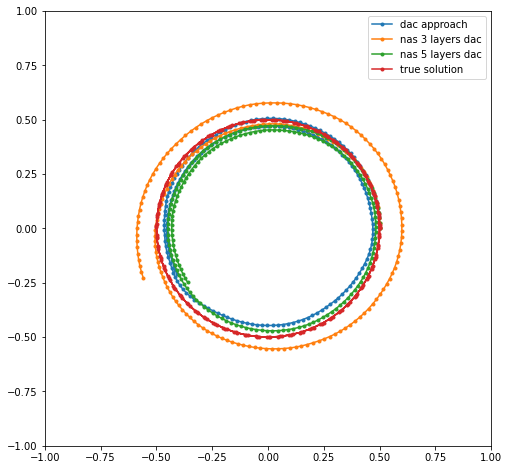

In [140]:
y0 = np.array([0.5, 0])
delta_t = 0.1
tstar = 0.1
max_t_prediction = 20

validation_dac = predict_dac(dac_model, y0, tstar, max_t_prediction)
validation_nas_3_dac = predict_dac(mlpnas_best_model_3_layer_dac, y0, tstar, max_t_prediction)
validation_nas_5_dac = predict_dac(mlpnas_best_model_5_layer_dac, y0, tstar, max_t_prediction)
#validation_dac = predict_dac(dac_model, y0, tstar, max_t_prediction)

times = np.arange(0, max_t_prediction, delta_t)
true_solution = [solution_simple_ODE(t, y0) for t in times]

fig, ax = generate_figure(figsize=(8,8), xlim=[-1, 1], ylim=[-1, 1])

ax = plot_ode_solution(ax, validation_dac, label="dac approach")
ax = plot_ode_solution(ax, validation_nas_3_dac, label="nas 3 layers dac")
ax = plot_ode_solution(ax, validation_nas_5_dac, label="nas 5 layers dac")
ax = plot_ode_solution(ax, true_solution, label="true solution")

plt.legend()
plt.savefig("proof_of_concept.pdf", bbox_inches="tight")
plt.show()

In [141]:
print("nas REINFORCE 3 layer euclidean distance: ",compute_euclidean_distance(true_solution,validation_nas_3_dac))
print("nas REINFORCE 5 layer euclidean distance: ",compute_euclidean_distance(true_solution,validation_nas_5_dac))
print("DAC approach euclidean distance: ",compute_euclidean_distance(true_solution,validation_dac))

nas REINFORCE 3 layer euclidean distance:  116.00354476127225
nas REINFORCE 3 layer euclidean distance:  97.15994681051136
DAC approach euclidean distance:  98.09656461583111


In [142]:
#train with more epoch
mlpnas_best_model_3_layer_dac = mlpnas_reinforce_3_layers.model_generator.create_model(encoded_sequence,2)
#mlpnas_best_model_3_layer_dac
mlpnas_best_model_5_layer_dac = mlpnas_reinforce_5_layers.model_generator.create_model(encoded_sequence,2)
dac_model = MLP_DAC()
train(mlpnas_best_model_3_layer_dac, train_dataloader_dac, 5)
train(mlpnas_best_model_5_layer_dac, train_dataloader_dac, 5)
train(dac_model, train_dataloader_dac, 5)

Starting epoch 1...
[epoch 1, batch 200] loss: 0.017
[epoch 1, batch 400] loss: 0.000
[epoch 1, batch 600] loss: 0.000
[epoch 1, batch 800] loss: 0.000
[epoch 1, batch 1000] loss: 0.000
[epoch 1, batch 1200] loss: 0.000
[epoch 1, batch 1400] loss: 0.000
[epoch 1, batch 1600] loss: 0.000
[epoch 1, batch 1800] loss: 0.000
[epoch 1, batch 2000] loss: 0.000
[epoch 1, batch 2200] loss: 0.000
[epoch 1, batch 2400] loss: 0.000
[epoch 1, batch 2600] loss: 0.000
[epoch 1, batch 2800] loss: 0.000
[epoch 1, batch 3000] loss: 0.000
[epoch 1, batch 3200] loss: 0.000
[epoch 1, batch 3400] loss: 0.000
[epoch 1, batch 3600] loss: 0.000
Starting epoch 2...
[epoch 2, batch 200] loss: 0.000
[epoch 2, batch 400] loss: 0.000
[epoch 2, batch 600] loss: 0.000
[epoch 2, batch 800] loss: 0.000
[epoch 2, batch 1000] loss: 0.000
[epoch 2, batch 1200] loss: 0.000
[epoch 2, batch 1400] loss: 0.000
[epoch 2, batch 1600] loss: 0.000
[epoch 2, batch 1800] loss: 0.000
[epoch 2, batch 2000] loss: 0.000
[epoch 2, batch 

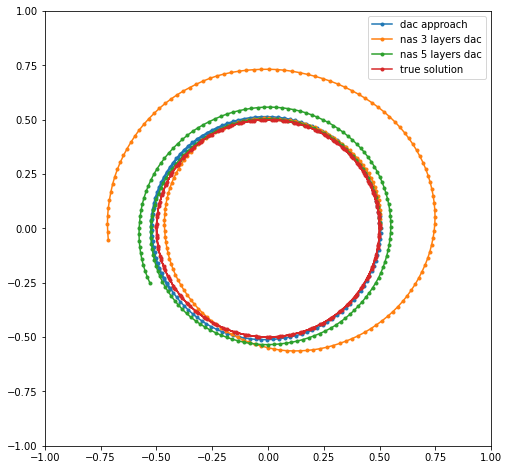

In [143]:
y0 = np.array([0.5, 0])
delta_t = 0.1
tstar = 0.1
max_t_prediction = 20

validation_dac = predict_dac(dac_model, y0, tstar, max_t_prediction)
validation_nas_3_dac = predict_dac(mlpnas_best_model_3_layer_dac, y0, tstar, max_t_prediction)
validation_nas_5_dac = predict_dac(mlpnas_best_model_5_layer_dac, y0, tstar, max_t_prediction)
#validation_dac = predict_dac(dac_model, y0, tstar, max_t_prediction)

times = np.arange(0, max_t_prediction, delta_t)
true_solution = [solution_simple_ODE(t, y0) for t in times]

fig, ax = generate_figure(figsize=(8,8), xlim=[-1, 1], ylim=[-1, 1])

ax = plot_ode_solution(ax, validation_dac, label="dac approach")
ax = plot_ode_solution(ax, validation_nas_3_dac, label="nas 3 layers dac")
ax = plot_ode_solution(ax, validation_nas_5_dac, label="nas 5 layers dac")
ax = plot_ode_solution(ax, true_solution, label="true solution")

plt.legend()
plt.savefig("proof_of_concept.pdf", bbox_inches="tight")
plt.show()

In [144]:
print("nas REINFORCE 3 layer euclidean distance: ",compute_euclidean_distance(true_solution,validation_nas_3_dac))
print("nas REINFORCE 3 layer euclidean distance: ",compute_euclidean_distance(true_solution,validation_nas_5_dac))
print("DAC approach euclidean distance: ",compute_euclidean_distance(true_solution,validation_dac))

nas REINFORCE 3 layer euclidean distance:  136.91923915508926
nas REINFORCE 3 layer euclidean distance:  115.7078102811512
DAC approach euclidean distance:  107.31335300287824


# Separate NAS experiments for DAC approach

In [156]:
dac_mlpnas_reinforce_2_layers = MLPNAS(max_architecture_length = 2)
dac_data_2_layers = dac_mlpnas_reinforce_2_layers.search(2,train_dataloader_dac,REINFORCE=True)

Generate Architecture Samples...
--------------------------------
Evaluating architectures in controller_sampling_epoch:  0
  training architecture:  0
  training architecture:  1
  training architecture:  2
  training architecture:  3
  training architecture:  4
  training architecture:  5
  training architecture:  6
  training architecture:  7
  training architecture:  8
  training architecture:  9
Training Controller...
Training Controller Model in epoch:  0
Training Controller Model in epoch:  1
Training Controller Model in epoch:  2
Generate Architecture Samples...
--------------------------------
Evaluating architectures in controller_sampling_epoch:  1
  training architecture:  0
  training architecture:  1
  training architecture:  2
  training architecture:  3
  training architecture:  4
  training architecture:  5
  training architecture:  6
  training architecture:  7
  training architecture:  8
  training architecture:  9
Training Controller...
Training Controller Model in 

In [157]:
dac_data_2_layers

[[[(256, 'elu'), (128, 'tanh')], 4.442688869226913],
 [[(256, 'relu'), (16, 'relu')], 17.165647318599895],
 [[(16, 'tanh'), (16, 'tanh')], 81.096304804174],
 [[(1024, 'tanh'), (512, 'elu')], 1.5486917788248036],
 [[(512, 'relu'), (1024, 'tanh')], 1.3160453287637779],
 [[(8, 'tanh'), (128, 'relu')], 54.704112643477856],
 [[(16, 'elu'), (16, 'elu')], 109.36557800650189],
 [[(8, 'elu'), (8, 'tanh')], 307.67000257538166],
 [[(64, 'relu'), (8, 'elu')], 90.74250568296702],
 [[(64, 'elu'), (64, 'relu')], 16.705154576204222],
 [[(1024, 'relu'), (16, 'elu')], 5.412687841001798],
 [[(16, 'relu'), (8, 'relu')], 304.23591638565995],
 [[(32, 'tanh'), (128, 'elu')], 13.521228280915238],
 [[(128, 'elu'), (128, 'tanh')], 4.880534216066735],
 [[(512, 'tanh'), (1024, 'relu')], 0.9892724314866541],
 [[(32, 'elu'), (128, 'relu')], 17.832929291867913],
 [[(64, 'elu'), (8, 'elu')], 78.70698342795367],
 [[(128, 'tanh'), (32, 'tanh')], 13.78391338630172],
 [[(1024, 'tanh'), (512, 'relu')], 1.2501352979298872]

In [158]:
dac_mlpnas_reinforce_3_layers = MLPNAS(max_architecture_length = 3)
dac_data_3_layers = dac_mlpnas_reinforce_3_layers.search(2,train_dataloader_dac,REINFORCE=True)

Generate Architecture Samples...
--------------------------------
Evaluating architectures in controller_sampling_epoch:  0
  training architecture:  0
  training architecture:  1
  training architecture:  2
  training architecture:  3
  training architecture:  4
  training architecture:  5
  training architecture:  6
  training architecture:  7
  training architecture:  8
  training architecture:  9
Training Controller...
Training Controller Model in epoch:  0
Training Controller Model in epoch:  1
Training Controller Model in epoch:  2
Generate Architecture Samples...
--------------------------------
Evaluating architectures in controller_sampling_epoch:  1
  training architecture:  0
  training architecture:  1
  training architecture:  2
  training architecture:  3
  training architecture:  4
  training architecture:  5
  training architecture:  6
  training architecture:  7
  training architecture:  8
  training architecture:  9
Training Controller...
Training Controller Model in 

In [162]:
dac_data_3_layers 

[[[(8, 'elu'), (16, 'tanh'), (64, 'relu')], 68.23276567927678],
 [[(256, 'relu'), (512, 'tanh'), (512, 'tanh')], 1.4743688730544022],
 [[(128, 'tanh'), (256, 'tanh'), (8, 'tanh')], 9.624785134652484],
 [[(256, 'elu'), (256, 'relu'), (16, 'relu')], 4.902567106001243],
 [[(256, 'relu'), (16, 'elu'), (32, 'elu')], 16.99728873399772],
 [[(128, 'tanh'), (1024, 'relu'), (8, 'relu')], 3.7067501061937946],
 [[(512, 'elu'), (256, 'tanh'), (8, 'tanh')], 5.548453970631272],
 [[(8, 'relu'), (1024, 'tanh'), (32, 'elu')], 30.95633492936031],
 [[(512, 'relu'), (256, 'tanh'), (64, 'tanh')], 2.6084088442009943],
 [[(16, 'tanh'), (256, 'tanh'), (8, 'elu')], 31.06868634064449],
 [[(16, 'tanh'), (64, 'elu'), (1024, 'tanh')], 6.945144684004845],
 [[(32, 'relu'), (16, 'elu'), (128, 'relu')], 37.751500790436694],
 [[(512, 'tanh'), (32, 'elu'), (1024, 'tanh')], 3.749224063802842],
 [[(32, 'elu'), (16, 'tanh'), (32, 'elu')], 69.65271024935646],
 [[(1024, 'relu'), (32, 'tanh'), (8, 'relu')], 9.082431817736051],

In [161]:
encoded_sequence = dac_mlpnas_reinforce_2_layers.encode_sequence([(512, 'tanh'), (1024, 'relu')])
dac_mlpnas_best_model_2_layer = dac_mlpnas_reinforce_2_layers.model_generator.create_model(encoded_sequence,2)
dac_mlpnas_best_model_2_layer

Sequential(
  (0): Linear(in_features=2, out_features=512, bias=True)
  (1): Tanh()
  (2): Linear(in_features=512, out_features=1024, bias=True)
  (3): Tanh()
  (4): Linear(in_features=1024, out_features=2, bias=True)
)

In [163]:
encoded_sequence = dac_mlpnas_reinforce_3_layers.encode_sequence([(256, 'relu'), (512, 'tanh'), (512, 'tanh')])
dac_mlpnas_best_model_3_layer = dac_mlpnas_reinforce_3_layers.model_generator.create_model(encoded_sequence,2)
dac_mlpnas_best_model_3_layer

Sequential(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): Tanh()
  (4): Linear(in_features=512, out_features=512, bias=True)
  (5): Tanh()
  (6): Linear(in_features=512, out_features=2, bias=True)
)

In [164]:
train(dac_mlpnas_best_model_2_layer, train_dataloader_dac, 3)

Starting epoch 1...
[epoch 1, batch 200] loss: 0.004
[epoch 1, batch 400] loss: 0.000
[epoch 1, batch 600] loss: 0.000
[epoch 1, batch 800] loss: 0.000
[epoch 1, batch 1000] loss: 0.000
[epoch 1, batch 1200] loss: 0.000
[epoch 1, batch 1400] loss: 0.000
[epoch 1, batch 1600] loss: 0.000
[epoch 1, batch 1800] loss: 0.000
[epoch 1, batch 2000] loss: 0.000
[epoch 1, batch 2200] loss: 0.000
[epoch 1, batch 2400] loss: 0.000
[epoch 1, batch 2600] loss: 0.000
[epoch 1, batch 2800] loss: 0.000
[epoch 1, batch 3000] loss: 0.000
[epoch 1, batch 3200] loss: 0.000
[epoch 1, batch 3400] loss: 0.000
[epoch 1, batch 3600] loss: 0.000
Starting epoch 2...
[epoch 2, batch 200] loss: 0.000
[epoch 2, batch 400] loss: 0.000
[epoch 2, batch 600] loss: 0.000
[epoch 2, batch 800] loss: 0.000
[epoch 2, batch 1000] loss: 0.000
[epoch 2, batch 1200] loss: 0.000
[epoch 2, batch 1400] loss: 0.000
[epoch 2, batch 1600] loss: 0.000
[epoch 2, batch 1800] loss: 0.000
[epoch 2, batch 2000] loss: 0.000
[epoch 2, batch 

In [165]:
train(dac_mlpnas_best_model_3_layer, train_dataloader_dac, 3)

Starting epoch 1...
[epoch 1, batch 200] loss: 0.008
[epoch 1, batch 400] loss: 0.000
[epoch 1, batch 600] loss: 0.000
[epoch 1, batch 800] loss: 0.000
[epoch 1, batch 1000] loss: 0.000
[epoch 1, batch 1200] loss: 0.000
[epoch 1, batch 1400] loss: 0.000
[epoch 1, batch 1600] loss: 0.000
[epoch 1, batch 1800] loss: 0.000
[epoch 1, batch 2000] loss: 0.000
[epoch 1, batch 2200] loss: 0.000
[epoch 1, batch 2400] loss: 0.000
[epoch 1, batch 2600] loss: 0.000
[epoch 1, batch 2800] loss: 0.000
[epoch 1, batch 3000] loss: 0.000
[epoch 1, batch 3200] loss: 0.000
[epoch 1, batch 3400] loss: 0.000
[epoch 1, batch 3600] loss: 0.000
Starting epoch 2...
[epoch 2, batch 200] loss: 0.000
[epoch 2, batch 400] loss: 0.000
[epoch 2, batch 600] loss: 0.000
[epoch 2, batch 800] loss: 0.000
[epoch 2, batch 1000] loss: 0.000
[epoch 2, batch 1200] loss: 0.000
[epoch 2, batch 1400] loss: 0.000
[epoch 2, batch 1600] loss: 0.000
[epoch 2, batch 1800] loss: 0.000
[epoch 2, batch 2000] loss: 0.000
[epoch 2, batch 

In [166]:
dac_model = MLP_DAC()
train(dac_model, train_dataloader_dac, 3)

Starting epoch 1...
[epoch 1, batch 200] loss: 0.193
[epoch 1, batch 400] loss: 0.043
[epoch 1, batch 600] loss: 0.003
[epoch 1, batch 800] loss: 0.001
[epoch 1, batch 1000] loss: 0.000
[epoch 1, batch 1200] loss: 0.000
[epoch 1, batch 1400] loss: 0.000
[epoch 1, batch 1600] loss: 0.000
[epoch 1, batch 1800] loss: 0.000
[epoch 1, batch 2000] loss: 0.000
[epoch 1, batch 2200] loss: 0.000
[epoch 1, batch 2400] loss: 0.000
[epoch 1, batch 2600] loss: 0.000
[epoch 1, batch 2800] loss: 0.000
[epoch 1, batch 3000] loss: 0.000
[epoch 1, batch 3200] loss: 0.000
[epoch 1, batch 3400] loss: 0.000
[epoch 1, batch 3600] loss: 0.000
Starting epoch 2...
[epoch 2, batch 200] loss: 0.000
[epoch 2, batch 400] loss: 0.000
[epoch 2, batch 600] loss: 0.000
[epoch 2, batch 800] loss: 0.000
[epoch 2, batch 1000] loss: 0.000
[epoch 2, batch 1200] loss: 0.000
[epoch 2, batch 1400] loss: 0.000
[epoch 2, batch 1600] loss: 0.000
[epoch 2, batch 1800] loss: 0.000
[epoch 2, batch 2000] loss: 0.000
[epoch 2, batch 

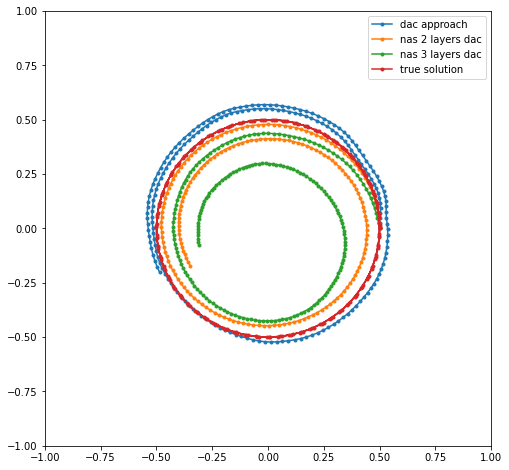

In [168]:
y0 = np.array([0.5, 0])
delta_t = 0.1
tstar = 0.1
max_t_prediction = 20

validation_dac = predict_dac(dac_model, y0, tstar, max_t_prediction)
validation_nas_2_dac = predict_dac(dac_mlpnas_best_model_2_layer, y0, tstar, max_t_prediction)
validation_nas_3_dac = predict_dac(dac_mlpnas_best_model_3_layer, y0, tstar, max_t_prediction)
#validation_dac = predict_dac(dac_model, y0, tstar, max_t_prediction)

times = np.arange(0, max_t_prediction, delta_t)
true_solution = [solution_simple_ODE(t, y0) for t in times]

fig, ax = generate_figure(figsize=(8,8), xlim=[-1, 1], ylim=[-1, 1])

ax = plot_ode_solution(ax, validation_dac, label="dac approach")
ax = plot_ode_solution(ax, validation_nas_2_dac, label="nas 2 layers dac")
ax = plot_ode_solution(ax, validation_nas_3_dac, label="nas 3 layers dac")
ax = plot_ode_solution(ax, true_solution, label="true solution")

plt.legend()
plt.savefig("proof_of_concept.pdf", bbox_inches="tight")
plt.show()

In [169]:
print("nas REINFORCE 2 layer euclidean distance: ",compute_euclidean_distance(true_solution,validation_nas_2_dac))
print("nas REINFORCE 3 layer euclidean distance: ",compute_euclidean_distance(true_solution,validation_nas_3_dac))
print("DAC approach euclidean distance: ",compute_euclidean_distance(true_solution,validation_dac))

nas REINFORCE 2 layer euclidean distance:  9.677396543077247
nas REINFORCE 3 layer euclidean distance:  9.147656333958198
DAC approach euclidean distance:  10.739230446920697


In [195]:
encoded_sequence = dac_mlpnas_reinforce_2_layers.encode_sequence([(512, 'tanh'), (1024, 'relu')])
dac_mlpnas_best_model_2_layer = dac_mlpnas_reinforce_2_layers.model_generator.create_model(encoded_sequence,2)
encoded_sequence = dac_mlpnas_reinforce_3_layers.encode_sequence([(256, 'relu'), (512, 'tanh'), (512, 'tanh')])
dac_mlpnas_best_model_3_layer = dac_mlpnas_reinforce_3_layers.model_generator.create_model(encoded_sequence,2)
dac_model = MLP_DAC()

In [196]:
train(dac_mlpnas_best_model_2_layer, train_dataloader_dac, 3)
train(dac_mlpnas_best_model_3_layer, train_dataloader_dac, 3)
train(dac_model, train_dataloader_dac, 3)

Starting epoch 1...
[epoch 1, batch 200] loss: 0.007
[epoch 1, batch 400] loss: 0.000
[epoch 1, batch 600] loss: 0.000
[epoch 1, batch 800] loss: 0.000
[epoch 1, batch 1000] loss: 0.000
[epoch 1, batch 1200] loss: 0.000
[epoch 1, batch 1400] loss: 0.000
[epoch 1, batch 1600] loss: 0.000
[epoch 1, batch 1800] loss: 0.000
[epoch 1, batch 2000] loss: 0.000
[epoch 1, batch 2200] loss: 0.000
[epoch 1, batch 2400] loss: 0.000
[epoch 1, batch 2600] loss: 0.000
[epoch 1, batch 2800] loss: 0.000
[epoch 1, batch 3000] loss: 0.000
[epoch 1, batch 3200] loss: 0.000
[epoch 1, batch 3400] loss: 0.000
[epoch 1, batch 3600] loss: 0.000
Starting epoch 2...
[epoch 2, batch 200] loss: 0.000
[epoch 2, batch 400] loss: 0.000
[epoch 2, batch 600] loss: 0.000
[epoch 2, batch 800] loss: 0.000
[epoch 2, batch 1000] loss: 0.000
[epoch 2, batch 1200] loss: 0.000
[epoch 2, batch 1400] loss: 0.000
[epoch 2, batch 1600] loss: 0.000
[epoch 2, batch 1800] loss: 0.000
[epoch 2, batch 2000] loss: 0.000
[epoch 2, batch 

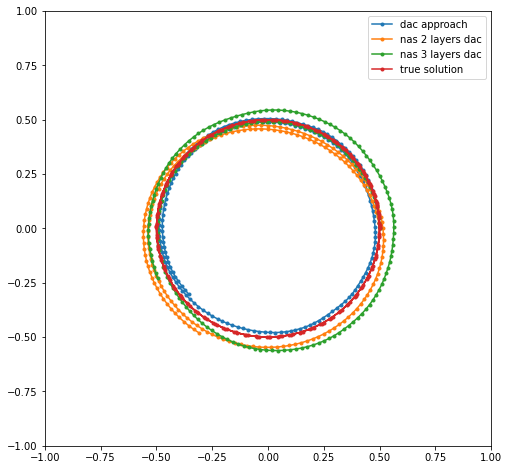

In [197]:
y0 = np.array([0.5, 0])
delta_t = 0.1
tstar = 0.1
max_t_prediction = 20

validation_dac = predict_dac(dac_model, y0, tstar, max_t_prediction)
validation_nas_2_dac = predict_dac(dac_mlpnas_best_model_2_layer, y0, tstar, max_t_prediction)
validation_nas_3_dac = predict_dac(dac_mlpnas_best_model_3_layer, y0, tstar, max_t_prediction)
#validation_dac = predict_dac(dac_model, y0, tstar, max_t_prediction)

times = np.arange(0, max_t_prediction, delta_t)
true_solution = [solution_simple_ODE(t, y0) for t in times]

fig, ax = generate_figure(figsize=(8,8), xlim=[-1, 1], ylim=[-1, 1])

ax = plot_ode_solution(ax, validation_dac, label="dac approach")
ax = plot_ode_solution(ax, validation_nas_2_dac, label="nas 2 layers dac")
ax = plot_ode_solution(ax, validation_nas_3_dac, label="nas 3 layers dac")
ax = plot_ode_solution(ax, true_solution, label="true solution")

plt.legend()
plt.savefig("proof_of_concept.pdf", bbox_inches="tight")
plt.show()

In [198]:
print("nas REINFORCE 2 layer euclidean distance: ",compute_euclidean_distance(true_solution,validation_nas_2_dac))
print("nas REINFORCE 3 layer euclidean distance: ",compute_euclidean_distance(true_solution,validation_nas_3_dac))
print("DAC approach euclidean distance: ",compute_euclidean_distance(true_solution,validation_dac))

nas REINFORCE 2 layer euclidean distance:  10.144637785115698
nas REINFORCE 3 layer euclidean distance:  10.601672479444044
DAC approach euclidean distance:  10.089012215359242


In [199]:
encoded_sequence = dac_mlpnas_reinforce_2_layers.encode_sequence([(512, 'tanh'), (1024, 'relu')])
dac_mlpnas_best_model_2_layer = dac_mlpnas_reinforce_2_layers.model_generator.create_model(encoded_sequence,2)
encoded_sequence = dac_mlpnas_reinforce_3_layers.encode_sequence([(256, 'relu'), (512, 'tanh'), (512, 'tanh')])
dac_mlpnas_best_model_3_layer = dac_mlpnas_reinforce_3_layers.model_generator.create_model(encoded_sequence,2)
dac_model = MLP_DAC()
train(dac_mlpnas_best_model_2_layer, train_dataloader_dac, 3)
train(dac_mlpnas_best_model_3_layer, train_dataloader_dac, 3)
train(dac_model, train_dataloader_dac, 3)

Starting epoch 1...
[epoch 1, batch 200] loss: 0.004
[epoch 1, batch 400] loss: 0.000
[epoch 1, batch 600] loss: 0.000
[epoch 1, batch 800] loss: 0.000
[epoch 1, batch 1000] loss: 0.000
[epoch 1, batch 1200] loss: 0.000
[epoch 1, batch 1400] loss: 0.000
[epoch 1, batch 1600] loss: 0.000
[epoch 1, batch 1800] loss: 0.000
[epoch 1, batch 2000] loss: 0.000
[epoch 1, batch 2200] loss: 0.000
[epoch 1, batch 2400] loss: 0.000
[epoch 1, batch 2600] loss: 0.000
[epoch 1, batch 2800] loss: 0.000
[epoch 1, batch 3000] loss: 0.000
[epoch 1, batch 3200] loss: 0.000
[epoch 1, batch 3400] loss: 0.000
[epoch 1, batch 3600] loss: 0.000
Starting epoch 2...
[epoch 2, batch 200] loss: 0.000
[epoch 2, batch 400] loss: 0.000
[epoch 2, batch 600] loss: 0.000
[epoch 2, batch 800] loss: 0.000
[epoch 2, batch 1000] loss: 0.000
[epoch 2, batch 1200] loss: 0.000
[epoch 2, batch 1400] loss: 0.000
[epoch 2, batch 1600] loss: 0.000
[epoch 2, batch 1800] loss: 0.000
[epoch 2, batch 2000] loss: 0.000
[epoch 2, batch 

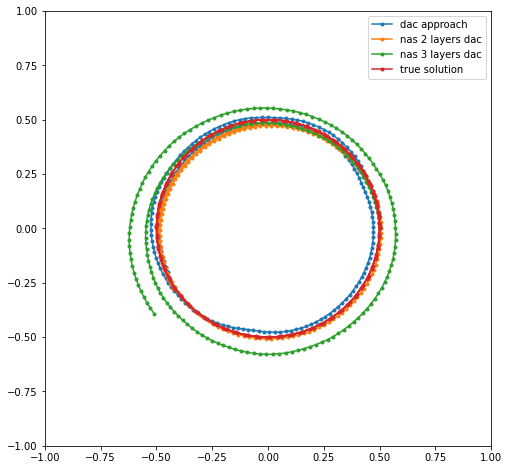

In [200]:
y0 = np.array([0.5, 0])
delta_t = 0.1
tstar = 0.1
max_t_prediction = 20

validation_dac = predict_dac(dac_model, y0, tstar, max_t_prediction)
validation_nas_2_dac = predict_dac(dac_mlpnas_best_model_2_layer, y0, tstar, max_t_prediction)
validation_nas_3_dac = predict_dac(dac_mlpnas_best_model_3_layer, y0, tstar, max_t_prediction)
#validation_dac = predict_dac(dac_model, y0, tstar, max_t_prediction)

times = np.arange(0, max_t_prediction, delta_t)
true_solution = [solution_simple_ODE(t, y0) for t in times]

fig, ax = generate_figure(figsize=(8,8), xlim=[-1, 1], ylim=[-1, 1])

ax = plot_ode_solution(ax, validation_dac, label="dac approach")
ax = plot_ode_solution(ax, validation_nas_2_dac, label="nas 2 layers dac")
ax = plot_ode_solution(ax, validation_nas_3_dac, label="nas 3 layers dac")
ax = plot_ode_solution(ax, true_solution, label="true solution")

plt.legend()
plt.savefig("proof_of_concept.pdf", bbox_inches="tight")
plt.show()

In [201]:
print("nas REINFORCE 2 layer euclidean distance: ",compute_euclidean_distance(true_solution,validation_nas_2_dac))
print("nas REINFORCE 3 layer euclidean distance: ",compute_euclidean_distance(true_solution,validation_nas_3_dac))
print("DAC approach euclidean distance: ",compute_euclidean_distance(true_solution,validation_dac))

nas REINFORCE 2 layer euclidean distance:  10.164470482389605
nas REINFORCE 3 layer euclidean distance:  10.791767945730015
DAC approach euclidean distance:  10.234014734348536


## 5. MLP Definition and Model Training

In [ ]:
class MLP_Standard(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )


    def forward(self, y0):
    
        return self.layers(y0)


class MLP_DAC(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 50),
            nn.ReLU(),
            nn.Linear(50, 2)
        )


    def forward(self, y0):
    
        return self.layers(y0)

In [ ]:
standard_model = MLP_Standard()
dac_model = MLP_DAC()

In [ ]:
def train(model, train_dataloader, n_epochs):
    
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    model.train()
    
    for epoch in range(n_epochs):
    
        print(f"Starting epoch {epoch+1}...")

        # Set running loss value
        running_loss = 0.0

        # Iterate over the DataLoader for training data
        for i, data in enumerate(train_dataloader, 0):

            # Get and prepare inputs
            inputs, targets = data
            inputs, targets = inputs.float(), targets.float()

            # Zero the parameter gradient
            optimizer.zero_grad()

            # forward, backward and optimize
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 200 == 199:
                print(f"[epoch {epoch + 1}, batch {i + 1}] loss: {running_loss / 200:.3f}")
                running_loss = 0.0

    print("Finished Training.")

In [ ]:
train(standard_model, train_dataloader_standard, 3)

Starting epoch 1...
[epoch 1, batch 200] loss: 0.252
[epoch 1, batch 400] loss: 0.222
[epoch 1, batch 600] loss: 0.230
[epoch 1, batch 800] loss: 0.238
[epoch 1, batch 1000] loss: 0.221
[epoch 1, batch 1200] loss: 0.209
[epoch 1, batch 1400] loss: 0.212
[epoch 1, batch 1600] loss: 0.192
[epoch 1, batch 1800] loss: 0.167
[epoch 1, batch 2000] loss: 0.157
[epoch 1, batch 2200] loss: 0.157
[epoch 1, batch 2400] loss: 0.128
[epoch 1, batch 2600] loss: 0.109
[epoch 1, batch 2800] loss: 0.089
[epoch 1, batch 3000] loss: 0.084
[epoch 1, batch 3200] loss: 0.083
[epoch 1, batch 3400] loss: 0.070
[epoch 1, batch 3600] loss: 0.068
Starting epoch 2...
[epoch 2, batch 200] loss: 0.058
[epoch 2, batch 400] loss: 0.048
[epoch 2, batch 600] loss: 0.048
[epoch 2, batch 800] loss: 0.041
[epoch 2, batch 1000] loss: 0.038
[epoch 2, batch 1200] loss: 0.033
[epoch 2, batch 1400] loss: 0.033
[epoch 2, batch 1600] loss: 0.028
[epoch 2, batch 1800] loss: 0.025
[epoch 2, batch 2000] loss: 0.023
[epoch 2, batch 

In [ ]:
train(dac_model, train_dataloader_dac, 3)

Starting epoch 1...
[epoch 1, batch 200] loss: 0.188
[epoch 1, batch 400] loss: 0.034
[epoch 1, batch 600] loss: 0.001
[epoch 1, batch 800] loss: 0.000
[epoch 1, batch 1000] loss: 0.000
[epoch 1, batch 1200] loss: 0.000
[epoch 1, batch 1400] loss: 0.000
[epoch 1, batch 1600] loss: 0.000
[epoch 1, batch 1800] loss: 0.000
[epoch 1, batch 2000] loss: 0.000
[epoch 1, batch 2200] loss: 0.000
[epoch 1, batch 2400] loss: 0.000
[epoch 1, batch 2600] loss: 0.000
[epoch 1, batch 2800] loss: 0.000
[epoch 1, batch 3000] loss: 0.000
[epoch 1, batch 3200] loss: 0.000
[epoch 1, batch 3400] loss: 0.000
[epoch 1, batch 3600] loss: 0.000
Starting epoch 2...
[epoch 2, batch 200] loss: 0.000
[epoch 2, batch 400] loss: 0.000
[epoch 2, batch 600] loss: 0.000
[epoch 2, batch 800] loss: 0.000
[epoch 2, batch 1000] loss: 0.000
[epoch 2, batch 1200] loss: 0.000
[epoch 2, batch 1400] loss: 0.000
[epoch 2, batch 1600] loss: 0.000
[epoch 2, batch 1800] loss: 0.000
[epoch 2, batch 2000] loss: 0.000
[epoch 2, batch 

## 6. Model Validation

In [129]:
def predict_standard(model, y0, delta_t, max_t_prediction):
    
    model.eval()
    
    times = np.arange(0, max_t_prediction, delta_t)
    
    with torch.no_grad():
        
        yt = [np.array(model(torch.Tensor(np.concatenate(([t], y0))))) for t in times]
    
    return yt


def predict_dac(model, y0, tstar, max_t_prediction):
    
    model.eval()
    # note: ideally tstar is an attribute of the training set or something and does not need to be an argument
    
    yt = [y0]
    n_applications = max_t_prediction // tstar
    n_application = 0
    
    while n_application < n_applications:
        
        with torch.no_grad():
            yt.append(np.array(model(torch.Tensor(yt[-1]))))
        
        n_application += 1
    
    return yt

In [ ]:
tstar

0.05

In [ ]:
y0 = np.array([0.5, 0])
delta_t = 0.1
tstar = 0.1
max_t_prediction = 20

validation_standard = predict_standard(standard_model, y0, delta_t, max_t_prediction)
#validation_dac = predict_dac(dac_model, y0, tstar, max_t_prediction)

times = np.arange(0, max_t_prediction, delta_t)
true_solution = [solution_simple_ODE(t, y0) for t in times]

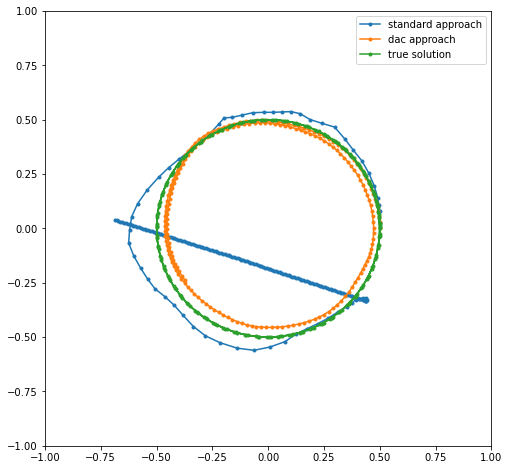

In [ ]:
fig, ax = generate_figure(figsize=(8,8), xlim=[-1, 1], ylim=[-1, 1])

ax = plot_ode_solution(ax, validation_standard, label="standard approach")
#ax = plot_ode_solution(ax, validation_dac, label="dac approach")
ax = plot_ode_solution(ax, true_solution, label="true solution")

plt.legend()
plt.savefig("proof_of_concept.pdf", bbox_inches="tight")
plt.show()

In [145]:
len(validation_standard)

200